<a href="https://colab.research.google.com/github/M1F1/MasterThesis/blob/master/SemiSupervisedComposableFrameworkWithMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Setup env 

In [1]:
from google.colab import drive
from pathlib import Path
import importlib
import pkg_resources


drive.mount('/content/gdrive')

if importlib.util.find_spec('wandb') is None:
  !pip install wandb

!wandb login

if importlib.util.find_spec('neptune') is None:
  !pip install neptune-client


if importlib.util.find_spec('pytorch_lightning') is None:
  !pip install pytorch-lightning

if importlib.util.find_spec('logzero') is None:
  !pip install logzero 

if importlib.util.find_spec('tensorboardX') is None:
  !pip install tensorboardX 

# if importlib.util.find_spec('lineflow') is None:
!pip install lineflow

if importlib.util.find_spec('optuna') is None:
  !pip install optuna

#if importlib.util.find_spec('gdown') is None:
!pip install gdown==3.11.0
  
if importlib.util.find_spec('transformers') is None:
  !pip install transformers 
  
if importlib.util.find_spec('nlpaug') is None:
  !pip install nlpaug 

if importlib.util.find_spec('torchtest') is None:
  !pip install torchtest 

import gdown
import contextlib
import glob
import shutil
import os
from functools import partial
from collections import OrderedDict
from typing import Dict
import re
import time
import math

import lineflow as lf
import lineflow.datasets as lfds

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler
from torch.nn import CrossEntropyLoss
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, RandomSampler, Dataset, sampler, ConcatDataset
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.optim.lr_scheduler import _LRScheduler, LambdaLR

import sklearn
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn import preprocessing
from matplotlib import pyplot as plt

import pytorch_lightning as pl
if pkg_resources.parse_version(pl.__version__) < pkg_resources.parse_version("0.7.1"):
  raise RuntimeError("PyTorch Lightning>=0.7.1 is required for this code.")
from pytorch_lightning import LightningModule
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.logging.neptune import NeptuneLogger 
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning import Callback
from pytorch_lightning.callbacks import LearningRateLogger
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint

from gensim.utils import tokenize as gensim_tokenizer
import gensim
from gensim.models.fasttext import FastText as FT_gensim

from transformers import BertModel, BertTokenizer, RobertaTokenizer, RobertaModel
from transformers import AdamW, get_linear_schedule_with_warmup, get_cosine_with_hard_restarts_schedule_with_warmup 
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
import operator
import spacy
import nltk
import toolz
from toolz import partial, compose, juxt, curry
from nltk.corpus import stopwords
import optuna
from optuna.integration import PyTorchLightningPruningCallback

import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas
import nlpaug.model.word_stats as nmw
import nlpaug.flow as nafc
from nlpaug.util import Action

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
!pip freeze > requirements.txt

os.environ['PROJECT_PATH'] = str(Path()/'gdrive'/'My Drive'/'praca_magisterska'/'pytorch_lightning')
os.environ['DATASETS_PATH'] = str(Path()/'gdrive'/'My Drive'/'praca_magisterska'/'pytorch_lightning'/'datasets')
os.environ['REQUIREMENTS_PATH'] = str(Path()/'requirements.txt')
os.environ['MODEL_CHECKPOINT_PATH'] = str(Path()/'model_checkpoints')
os.environ['SPELLING_PATH'] = str(Path()/'gdrive'/'My Drive'/'praca_magisterska'/'pytorch_lightning'/'nlpaug'/'spelling_en.txt') 
os.environ['NLPAUG_PATH'] = str(Path()/'gdrive'/'My Drive'/'praca_magisterska'/'pytorch_lightning'/'nlpaug')
artefacts_temp_dir = os.path.join(os.environ['PROJECT_PATH'], 'parametrized_nbs')

neptune_api_token_key_file = str(Path()/'gdrive'/'My Drive'/'praca_magisterska'/'neptune_api_token.txt')
with open (neptune_api_token_key_file, 'r') as f:
  os.environ['NEPTUNE_API_TOKEN'] = f.readlines()[0]

if not os.path.exists(artefacts_temp_dir):
  os.makedirs(artefacts_temp_dir)

if not os.path.exists(os.environ['MODEL_CHECKPOINT_PATH']):
  os.makedirs(os.environ['MODEL_CHECKPOINT_PATH'])




Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
     |████████████████████████████████| 1.4MB 6.9MB/s 
     |████████████████████████████████| 102kB 10.0MB/s 
     |████████████████████████████████| 163kB 31.6MB/s 
     |████████████████████████████████| 102kB 10.4MB/s 
     |████████████████████████████████| 122kB 29.8MB/s 
     |████████████████████████████████| 71kB 7.9MB/s 
     |████████████████████████████████| 71kB 8.5MB/s 
  Created wheel for gql: filename=gql-0.2.0-cp36-none-any.whl size=7630 sha2

### Utils

In [99]:
def compute_global_metric(outputs, metric):
    return sum([out[metric] for out in outputs]) / len(outputs)


def create_metrics_dict(phase_type: str, loss, labels, labels_hat, max_probs) -> dict:

    output_dict = {f'{phase_type}_loss': loss}
    
    metrics_keys = [
                    f'{phase_type}_accuracy_error',
                    f'{phase_type}_f1_error',
                    f'{phase_type}_recall_error',
                    f'{phase_type}_precision_error'
                   ]

    error_map = lambda x: 1-x

    error_metrics_values = juxt(
                                compose(error_map, partial(accuracy_score)),
                                compose(error_map, partial(f1_score, **{'average':'micro'})),
                                compose(error_map, partial(recall_score, **{'average':'micro'})),
                                compose(error_map, partial(precision_score, **{'average':'micro'}))
                               )(labels, labels_hat)


    output_dict.update(dict(zip(metrics_keys, error_metrics_values)))

    confident_keys = [
                      f'{phase_type}_max_confident',
                      f'{phase_type}_min_confident',
                      f'{phase_type}_mean_confident',
                      f'{phase_type}_std_confident'
                     ]
    confident_values = toolz.juxt(
                                  np.max,
                                  np.min, 
                                  np.mean,
                                  np.std,
                                 )(max_probs)

    output_dict.update(dict(zip(confident_keys, confident_values)))

    return output_dict


def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


def tfidf_tokenizer(text, token_pattern=r"(?u)\b\w\w+\b"):
    token_pattern = re.compile(token_pattern)
    return token_pattern.findall(text)


def create_tfidf_model(df: pd.DataFrame):  
  train_data = df['text'] 
  train_x = train_data.values
    
  train_x_tokens = [tfidf_tokenizer(x) for x in train_x]
    
  tfidf_model = nmw.TfIdf()
  tfidf_model.train(train_x_tokens)
  tfidf_model.save(os.environ['NLPAUG_PATH'])
  os.environ['TFIDF_MODEL_PATH']  = os.path.join(os.environ['NLPAUG_PATH'], 'tfidfaug_w2tfidf.txt')
  os.listdir(os.environ['NLPAUG_PATH'])


class MetricsCallback(Callback):
    """PyTorch Lightning metric callback."""

    def __init__(self):
        super().__init__()
        self.metrics = []

    def on_validation_end(self, trainer, pl_module):
        self.metrics.append(trainer.callback_metric)


# credits:
# https://github.com/galatolofederico/pytorch-balanced-batch/blob/master/sampler.py        
#-------------------------------------------------------------------------------
class BalancedBatchSampler(torch.utils.data.sampler.Sampler):
    def __init__(self, dataset, labels=None):
        self.labels = labels
        self.dataset = dict()
        self.balanced_max = 0
        # Save all the indices for all the classes
        for idx in range(0, len(dataset)):
            label = self._get_label(dataset, idx)
            if label not in self.dataset:
                self.dataset[label] = list()
            self.dataset[label].append(idx)
            self.balanced_max = len(self.dataset[label]) \
                if len(self.dataset[label]) > self.balanced_max else self.balanced_max
        
        # Oversample the classes with fewer elements than the max
        for label in self.dataset:
            while len(self.dataset[label]) < self.balanced_max:
                self.dataset[label].append(random.choice(self.dataset[label]))
        self.keys = list(self.dataset.keys())
        self.currentkey = 0
        self.indices = [-1]*len(self.keys)

    def __iter__(self):
        while self.indices[self.currentkey] < self.balanced_max - 1:
            self.indices[self.currentkey] += 1
            yield self.dataset[self.keys[self.currentkey]][self.indices[self.currentkey]]
            self.currentkey = (self.currentkey + 1) % len(self.keys)
        self.indices = [-1]*len(self.keys)
    
    def _get_label(self, dataset, idx, labels = None):
        if self.labels is not None:
            return self.labels[idx].item()
        else:
            raise Exception("You should pass the tensor of labels to the constructor as second argument")

    def __len__(self):
        return self.balanced_max*len(self.keys)
#-------------------------------------------------------------------------------


# credits:
# https://github.com/pytorch/pytorch/issues/3223
#-------------------------------------------------------------------------------
def size_splits(tensor, split_sizes, dim=0):
    """Splits the tensor according to chunks of split_sizes.
    
    Arguments:
        tensor (Tensor): tensor to split.
        split_sizes (list(int)): sizes of chunks
        dim (int): dimension along which to split the tensor.
    """
    if dim < 0:
        dim += tensor.dim()
    
    dim_size = tensor.size(dim)
    if dim_size != torch.sum(torch.Tensor(split_sizes)):
        raise KeyError("Sum of split sizes exceeds tensor dim")
    
    splits = torch.cumsum(torch.Tensor([0] + split_sizes), dim=0)[:-1]

    return tuple(tensor.narrow(int(dim), int(start), int(length)) 
        for start, length in zip(splits, split_sizes))
#-------------------------------------------------------------------------------


# credits:
# Modified StepLR from https://pytorch.org/docs/stable/optim.html
#-------------------------------------------------------------------------------
class StepLR(_LRScheduler):
    """Decays the learning rate of each parameter group by gamma every
    step_size epochs. Notice that such decay can happen simultaneously with
    other changes to the learning rate from outside this scheduler. When
    last_epoch=-1, sets initial lr as lr.

    Args:
        optimizer (Optimizer): Wrapped optimizer.
        step_size (int): Period of learning rate decay.
        gamma (float): Multiplicative factor of learning rate decay.
            Default: 0.1.
        last_epoch (int): The index of last epoch. Default: -1.

    Example:
        >>> # Assuming optimizer uses lr = 0.05 for all groups
        >>> # lr = 0.05     if epoch < 30
        >>> # lr = 0.005    if 30 <= epoch < 60
        >>> # lr = 0.0005   if 60 <= epoch < 90
        >>> # ...
        >>> scheduler = StepLR(optimizer, step_size=30, gamma=0.1)
        >>> for epoch in range(100):
        >>>     train(...)
        >>>     validate(...)
        >>>     scheduler.step()
    """

    def __init__(self, optimizer, step_size, decay_step, gamma=0.1, last_epoch=-1):
        self.step_size = step_size
        self.gamma = gamma
        # adding constant initial learning rate for n decay_step
        self.decay_step = decay_step 
        super(StepLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        if not self._get_lr_called_within_step:
            warnings.warn("To get the last learning rate computed by the scheduler, "
                          "please use `get_last_lr()`.", UserWarning)
            
        if (self.optimizer._step_count < self.decay_step) or (self.last_epoch == 0) or (self.last_epoch % self.step_size != 0):
            return [group['lr'] for group in self.optimizer.param_groups]
            
        return [group['lr'] * self.gamma for group in self.optimizer.param_groups]

    def _get_closed_form_lr(self):
        return [base_lr * self.gamma ** (self.last_epoch // self.step_size)
                for base_lr in self.base_lrs]        
#-------------------------------------------------------------------------------


# credits:
# https://www.kaggle.com/indralin/train-uses-tpu-in-kaggle-kernel-baseline-0-82
#-------------------------------------------------------------------------------
def get_cosine_schedule_with_warmup(optimizer,
                                    num_warmup_steps,
                                    num_training_steps,
                                    num_cycles=7./16.,
                                    last_epoch=-1):
    def _lr_lambda(current_step):
        if current_step < num_warmup_steps:
            return float(current_step) / float(max(1, num_warmup_steps))
        no_progress = float(current_step - num_warmup_steps) / \
            float(max(1, num_training_steps - num_warmup_steps))
        return max(0., math.cos(math.pi * num_cycles * no_progress))

    return LambdaLR(optimizer, _lr_lambda, last_epoch)
#-------------------------------------------------------------------------------


# credits:
# https://www.kaggle.com/christofhenkel/how-to-preprocessing-when-using-embeddings
#-------------------------------------------------------------------------------
def build_vocab(sentences, verbose =  True):
    """
    :param sentences: list of list of words
    :return: dictionary of words and their count
    """
    vocab = {}
    for sentence in tqdm(sentences, disable = (not verbose)):
        for word in sentence:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab

    import operator 


def check_coverage(vocab,embeddings_index):
    a = {}
    oov = {}
    k = 0
    i = 0
    for word in tqdm(vocab):
        try:
            a[word] = embeddings_index[word]
            k += vocab[word]
        except:

            oov[word] = vocab[word]
            i += vocab[word]
            pass

    print('Found embeddings for {:.2%} of vocab'.format(len(a) / len(vocab)))
    print('Found embeddings for  {:.2%} of all text'.format(k / (k + i)))
    sorted_x = sorted(oov.items(), key=operator.itemgetter(1))[::-1]

    return sorted_x
#-------------------------------------------------------------------------------


def create_ft_embeder():
  source ='./cc.en.300.bin' 
  my_file = Path(source)
  if not my_file.is_file():
    !wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
    !gunzip -k cc.en.300.bin.gz
  print('Loading fastText model into memory, it can take a while...')
  start = time.time()
  ft = gensim.models.FastText.load_fasttext_format("./cc.en.300.bin")
  end = time.time()
  duration =  end - start
  print(f'Loading took: {duration} s')
  return ft
  

def create_spacy_nlp_embeder():
  my_file = Path("./cc.en.300.vec")
  if not my_file.is_file():
    !wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
  my_file2 = Path("./en_vectors_wiki_lg")
  if not my_file2.is_file():
    !python -m spacy init-model en /en_vectors_wiki_lg --vectors-loc cc.en.300.vec.gz
    
  print('Loading fastText vectors into spaCy model into memory, it can take a while...')
  start = time.time()
  nlp = spacy.load("/en_vectors_wiki_lg")
  end = time.time()
  duration =  end - start
  print(f'Loading took: {duration} s')
  return nlp 

## Data Manipulations

##### Prepere texts embeddings

In [98]:
#nlp = create_spacy_nlp_embeder()
# embeddings_index = get_ft_word_vectors_indices()

### Datasets EDA

#### IMDB

In [ ]:
# train = lfds.Imdb('train')
# test = lfds.Imdb('test')
# dataset = train + test
# ds = dataset.map(lambda x: {'text': x[0], 'label':x[1], 'tokens_len': len(list(gensim_tokenizer(x[0])))})
# df = pd.DataFrame(ds)
# df['tokens_len'].describe()

#### MR

In [131]:
dataset_path = str(Path()/
                        'gdrive'/
                        'My Drive'/
                        'praca_magisterska'/
                        'pytorch_lightning'/
                        'datasets'/
                        'mr_with_bt2.csv')
df = pd.read_csv(dataset_path, index_col=None)
df['totalwords'] = df['text'].str.split().str.len()
df['totalwords'].describe()

count    2000.000000
mean      737.534500
std       324.113972
min        17.000000
25%       520.750000
50%       688.500000
75%       893.250000
max      2660.000000
Name: totalwords, dtype: float64

In [132]:
remove_html_tags = re.compile(r'<.*?>')
remove_punctuation = re.compile(r'[^\w\s]+')
remove_extra_whitespaces = re.compile(r' +')

p1 = curry(remove_html_tags.sub)('') 
p2 = curry(remove_punctuation.sub)('') 
p3 = curry(remove_extra_whitespaces.sub)(' ') 
p4 = str.lower
processing = compose(p4, p3, p2, p1)

df['text'] = df['text'].apply(processing)
sentences = df["text"].progress_apply(lambda x: x.split()).values
vocab = build_vocab(sentences)
print({k: vocab[k] for k in list(vocab)[:5]})

oov = check_coverage(vocab, embeddings_index)


100%|██████████| 2000/2000 [00:00<00:00, 5912.98it/s]


{'warner': 45, 'brothers': 218, 'has': 4715, 'scored': 16, 'another': 1111}


100%|██████████| 47773/47773 [00:00<00:00, 53408.93it/s]


Found embeddings for 99.63% of vocab
Found embeddings for  99.97% of all text


#### NLUHD

In [ ]:
# datasets_path = str(Path()/'gdrive'/'My Drive'/'praca_magisterska'/'pytorch_lightning'/'datasets')
# NLU_HD_path = os.path.join(datasets_path,'NLU-Data-Home-Domain-Annotated-All.csv')
# print(NLU_HD_path)
# # df = pd.read_csv(str(NLU_HD_path), delimiter=';')[['intent', 'answer_annotation']]
# df = pd.read_csv(str(NLU_HD_path), delimiter=';')[['intent', 'answer_annotation', 'scenario']]
# df['intent'] = df[['scenario', 'intent']].agg('-'.join, axis=1) 
# del df['scenario']
# df = df[df['answer_annotation'].notna()]
# df = df.rename(columns={"answer_annotation": "text"})
# nlp = spacy.load("en", disable=['parser', 'tagger', 'ner'])

# df['text'] = df['text'].apply(normalize,
#                               lowercase=True,
#                               remove_stopwords=False,
#                               with_ner_tags=False,
#                               nlp=nlp) 
# # df.to_csv(os.path.join(datasets_path,'NLU-Data-Home-Domain-preprocessed-without-ner_no-scenario.csv'))
# df.to_csv(os.path.join(datasets_path,'NLU-Data-Home-Domain-preprocessed-without-ner.csv'))
# df['intent'].value_counts().plot(kind="bar", figsize= (21,20))

### FixMatch Augmentations

#### FixMatch Image Augmentation

In [ ]:
# credits: 
# https://github.com/ildoonet/pytorch-randaugment/blob/master/RandAugment/augmentations.py
# https://github.com/google-research/fixmatch/blob/master/third_party/auto_augment/augmentations.py
# https://github.com/google-research/fixmatch/blob/master/libml/ctaugment.py

#-------------------------------------------------------------------------------
import logging
import random

import numpy as np
import PIL
import PIL.ImageOps
import PIL.ImageEnhance
import PIL.ImageDraw
from PIL import Image

logger = logging.getLogger(__name__)

PARAMETER_MAX = 10


def AutoContrast(img, **kwarg):
    return PIL.ImageOps.autocontrast(img)


def Brightness(img, v, max_v, bias=0):
    v = _float_parameter(v, max_v) + bias
    return PIL.ImageEnhance.Brightness(img).enhance(v)


def Color(img, v, max_v, bias=0):
    v = _float_parameter(v, max_v) + bias
    return PIL.ImageEnhance.Color(img).enhance(v)


def Contrast(img, v, max_v, bias=0):
    v = _float_parameter(v, max_v) + bias
    return PIL.ImageEnhance.Contrast(img).enhance(v)


def Cutout(img, v, max_v, bias=0):
    if v == 0:
        return img
    v = _float_parameter(v, max_v) + bias
    v = int(v * min(img.size))
    return CutoutAbs(img, v)


def CutoutAbs(img, v, **kwarg):
    w, h = img.size
    x0 = np.random.uniform(0, w)
    y0 = np.random.uniform(0, h)
    x0 = int(max(0, x0 - v / 2.))
    y0 = int(max(0, y0 - v / 2.))
    x1 = int(min(w, x0 + v))
    y1 = int(min(h, y0 + v))
    xy = (x0, y0, x1, y1)
    # gray
    # color = (127, 127, 127)
    color = (255)
    img = img.copy()
    PIL.ImageDraw.Draw(img).rectangle(xy, color)
    return img


def Equalize(img, **kwarg):
    return PIL.ImageOps.equalize(img)


def Identity(img, **kwarg):
    return img


def Invert(img, **kwarg):
    return PIL.ImageOps.invert(img)


def Posterize(img, v, max_v, bias=0):
    v = _int_parameter(v, max_v) + bias
    return PIL.ImageOps.posterize(img, v)


def Rotate(img, v, max_v, bias=0):
    v = _int_parameter(v, max_v) + bias
    if random.random() < 0.5:
        v = -v
    return img.rotate(v)


def Sharpness(img, v, max_v, bias=0):
    v = _float_parameter(v, max_v) + bias
    return PIL.ImageEnhance.Sharpness(img).enhance(v)


def ShearX(img, v, max_v, bias=0):
    v = _float_parameter(v, max_v) + bias
    if random.random() < 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, v, 0, 0, 1, 0))


def ShearY(img, v, max_v, bias=0):
    v = _float_parameter(v, max_v) + bias
    if random.random() < 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, v, 1, 0))


def Solarize(img, v, max_v, bias=0):
    v = _int_parameter(v, max_v) + bias
    return PIL.ImageOps.solarize(img, 256 - v)


def SolarizeAdd(img, v, max_v, bias=0, threshold=128):
    v = _int_parameter(v, max_v) + bias
    if random.random() < 0.5:
        v = -v
    img_np = np.array(img).astype(np.int)
    img_np = img_np + v
    img_np = np.clip(img_np, 0, 255)
    img_np = img_np.astype(np.uint8)
    img = Image.fromarray(img_np)
    return PIL.ImageOps.solarize(img, threshold)


def TranslateX(img, v, max_v, bias=0):
    v = _float_parameter(v, max_v) + bias
    if random.random() < 0.5:
        v = -v
    v = int(v * img.size[0])
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, v, 0, 1, 0))


def TranslateY(img, v, max_v, bias=0):
    v = _float_parameter(v, max_v) + bias
    if random.random() < 0.5:
        v = -v
    v = int(v * img.size[1])
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, 0, 1, v))


def _float_parameter(v, max_v):
    return float(v) * max_v / PARAMETER_MAX


def _int_parameter(v, max_v):
    return int(v * max_v / PARAMETER_MAX)


def fixmatch_augment_pool():
    # FixMatch paper
    augs = [(AutoContrast, None, None),
            (Brightness, 0.9, 0.05),
            (Color, 0.9, 0.05),
            (Contrast, 0.9, 0.05),
            (Equalize, None, None),
            (Identity, None, None),
            (Posterize, 4, 4),
            (Rotate, 30, 0),
            (Sharpness, 0.9, 0.05),
            (ShearX, 0.3, 0),
            (ShearY, 0.3, 0),
            (Solarize, 256, 0),
            (TranslateX, 0.3, 0),
            (TranslateY, 0.3, 0)]
            
    return augs
    

#-------------------------------------------------------------------------------
class RandAugmentMCStrong(object):
    def __init__(self, n, m):
        assert n >= 1
        assert 1 <= m <= 10
        self.n = n
        self.m = m
        self.augment_pool = fixmatch_augment_pool()

    def __call__(self, img):
        ops = random.choices(self.augment_pool, k=self.n)
        for op, max_v, bias in ops:
            v = np.random.randint(1, self.m)
            if random.random() < 0.5:
                img = op(img, v=v, max_v=max_v, bias=bias)
        img = CutoutAbs(img, 16)
        return img

class RandAugmentMCWeak(object):
    def __init__(self, n, m):
        assert n >= 1
        assert 1 <= m <= 10
        self.n = n
        self.m = m
        self.augment_pool = fixmatch_augment_pool()

    def __call__(self, img):
        ops = random.choices(self.augment_pool, k=self.n)
        for op, max_v, bias in ops:
            v = np.random.randint(1, self.m)
            if random.random() < 0.5:
                img = op(img, v=v, max_v=max_v, bias=bias)
        return img

        
class TransformFixImage(object):
    def __init__(self, mean, std, n_strong, m_strong, n_weak, m_weak):
        self.weak = transforms.Compose([
            transforms.ToPILImage(),
            # transforms.RandomHorizontalFlip(),
            # transforms.RandomCrop(size=28,
            #                       padding=int(28*0.125),
            #                       padding_mode='reflect')
            RandAugmentMCWeak(n=n_weak, m=m_weak)
            ])
        self.strong = transforms.Compose([
            transforms.ToPILImage(),
            # transforms.RandomHorizontalFlip(),
            # transforms.RandomCrop(size=28,
            #                       padding=int(28*0.125),
            #                       padding_mode='reflect'),
            RandAugmentMCStrong(n=n_strong, m=m_strong)])
        self.normalize = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std)])

    def __call__(self, x):
        weak = self.weak(x)
        strong = self.strong(x)
        return self.normalize(weak), self.normalize(strong)


#### FixMatch Text Augmentation

In [ ]:
# ---------------------------------------------    
# augmentations on char level 
# ---------------------------------------------    
def print_augmentations(func, text):
  def wrapper():
    print("Augmentation function: ", func.__name__)
    print("Original: ")
    print(text)
    augmented_text = func(text)
    print("Augmention result: ")
    print(augmented_text)
    return augmented_text

  return wrapper() 

def substitute_character_by_keyboard_distance(text):
  aug = nac.KeyboardAug()
  augmented_text = aug.augment(text)
  return augmented_text

def insert_character_randomly(text):
  aug = nac.RandomCharAug(action="insert")
  augmented_text = aug.augment(text)
  return augmented_text 


def substitute_character_randomly(text):
  aug = nac.RandomCharAug(action="substitute")
  augmented_text = aug.augment(text)
  return augmented_text 


def delete_char_randomly(text):
  aug = nac.RandomCharAug(action="delete")
  augmented_text = aug.augment(text)
  return augmented_text 


def swap_character_randomly(text):
  aug = nac.RandomCharAug(action="swap")
  augmented_text = aug.augment(text)
  return augmented_text

# ---------------------------------------------    
# augmentations on word level 
# ---------------------------------------------    
# models - spelling_en.txt
# model_dir with fasttext or word2vec or glove 
# model dir with tf-idf

# its consume to much RAM
# def insert_word_randomly_by_word_embeddings_similarity(text):
#   # model_type: word2vec, glove or fasttext
#   aug = naw.WordEmbsAug(
#       model_type='word2vec', model_path=os.environ('WORD2VEC_MODEL_PATH'),
#       action="insert")
#   augmented_text = aug.augment(text)
#   print("Original:")
#   print(text)
#   print("Augmented Text:")
#   print(augmented_text)
#   return augmented_text


def insert_word_by_tf_idf_similarity(text):
  aug = naw.TfIdfAug(
      model_path=os.environ['NLPAUG_PATH'],
      action="insert")
  augmented_text = aug.augment(text)
  return augmented_text 



def split_word_to_two_tokens_randomly(text):
  aug = naw.SplitAug()
  augmented_text = aug.augment(text)
  return augmented_text 


def swap_word_randomly(text):
  aug = naw.RandomWordAug(action="swap")
  augmented_text = aug.augment(text)
  return augmented_text 


def substitute_word_by_antonym(text):
  aug = naw.AntonymAug()
  augmented_text = aug.augment(text)
  return augmented_text 


def substitute_word_by_spelling_mistake_words_dictionary(text):
  aug = naw.SpellingAug(os.environ['SPELLING_PATH'])
  augmented_text = aug.augment(text, n=1)
  return augmented_text 


def insert_word_by_contextual_word_embeddings(text):
  aug = naw.ContextualWordEmbsAug(
      model_path='bert-base-uncased', action="insert")
  augmented_text = aug.augment(text)
  return augmented_text


def subtitute_word_by_contextual_word_embeddings(text):
  aug = naw.ContextualWordEmbsAug(
           model_path='bert-base-uncased', action="substitute")
  augmented_text = aug.augment(text)
  return augmented_text


def substitute_word_by_WordNets_synonym(text):
  aug = naw.SynonymAug(aug_src='wordnet')
  augmented_text = aug.augment(text)
  return augmented_text
  
def fixmatch_weak_augment_pool():
    augs = [
            substitute_character_by_keyboard_distance,
            insert_character_randomly,
            substitute_character_randomly,
            delete_char_randomly,
            swap_character_randomly,
            # insert_word_randomly_by_word_embeddings_similarity,
            insert_word_by_tf_idf_similarity,
            split_word_to_two_tokens_randomly,
            swap_word_randomly,
            substitute_word_by_antonym,
            substitute_word_by_spelling_mistake_words_dictionary,
            insert_word_by_contextual_word_embeddings,
            subtitute_word_by_contextual_word_embeddings,
            substitute_word_by_WordNets_synonym,
           ]

    return augs

# def fixmatch_strong_augment_pool():
#     augs = [
#             insert_word_by_contextual_word_embeddings,
#             subtitute_word_by_contextual_word_embeddings,
#             substitute_word_by_WordNets_synonym,
#            ]

#     return augs


class WeakRandAugment(object):
  def __init__(self, n, show=False):
    """
    Parameters:
    n (int): number of operations

    """
    assert n >= 0
    self.n = n
    self.augment_pool = fixmatch_weak_augment_pool()
    self.show=show

  def __call__(self, text):
    if self.n <= 0:
      return text
    ops = random.choices(self.augment_pool, k=self.n)
    for op in ops:
        if random.random() < 1.:
          if self.show:
            text = print_augmentations(op, text)
          else:
            text = op(text)
    return text 

# not necessery
# class StrongRandAugment(object):
#   def __init__(self, n, show=False):
#     assert n >= 1
#     self.n = n
#     self.augment_pool = fixmatch_strong_augment_pool()
#     self.show= show

#   def __call__(self, text):
#     ops = random.choices(self.augment_pool, k=self.n)
#     for op in ops:
#       if random.random() < 1.:
#         if self.show:
#           text = print_augmentations(op, text)
#         else:
#           text = op(text)
#     return text 


class TransformFix(object):
  def __init__(self, n_weak=3, show=False):
  # def __init__(self, n_weak=3, n_strong=2, show=False):
    self.weak = WeakRandAugment(n=n_weak, show=show) 
    # self.strong = StrongRandAugment(n=n_strong, show=show)

  def __call__(self, x):
    weak = self.weak(x)
    # strong = self.strong(x)
    return weak #, strong



### Datasets Classes

In [ ]:
# !!!!!!!
# TODO: change dataset name and data_dict keys        
class SimpleTextDataset(Dataset):

    def __init__(self, x, y, transform=None):
        self.x = x
        self.y = y
        self.transform = transform

    def __getitem__(self, index):
        # special dict convention for f: process_NLUHD 
        data_dict = { 'text': self.x[index], 'label': self.y[index]}
        if self.transform is not None:
          return self.transform(data_dict)
        return tuple(data_dict.values()) 

    def __len__(self):
        return len(self.x)

class FixMatchAugmentedTextDataset(Dataset):

    def __init__(self, x, x_paraphrases, y,
                 model_preprocessing = None,
                 fix_match_augmentation = None, show=False):
        self.x = x
        self.x_paraphrases = x_paraphrases
        self.y = y
        self.model_preprocessing = model_preprocessing
        self.fix_match_augmentation = fix_match_augmentation
        self.show = show

    def __getitem__(self, index):
        # special dict convention for f: process_NLUHD 
        if self.fix_match_augmentation is not None:
          weak_augmented, strong_augmented = \
           self.fix_match_augmentation(self.x[index]), self.x_paraphrases[index] 
          if self.show:
            print_augmentations(lambda x: x, self.x_paraphrases[index])
        

        weak_aug_data_dict = { 'text': weak_augmented , 'label': self.y[index]}
        # add tfidf deletion or subsitution
        strong_aug_data_dict = { 'text': strong_augmented , 'label': self.y[index]}

        if self.model_preprocessing is not None:
          return self.model_preprocessing(weak_aug_data_dict), self.model_preprocessing(strong_aug_data_dict)

        return tuple(weak_aug_data_dict.values()), tuple(strong_aug_data_dict.values()) 

    def __len__(self):
        return len(self.x)

class FixMatchAugmentedImageDataset(Dataset):

    def __init__(self, x, y,
                 model_preprocessing = None,
                 fix_match_augmentation = None,
                 show=False):
        self.x = x
        self.y = y
        self.model_preprocessing = model_preprocessing
        self.fix_match_augmentation = fix_match_augmentation
        self.show = show

    def __getitem__(self, index):
        # special dict convention for f: process_NLUHD 
        if self.fix_match_augmentation is not None:
          weak_augmented, strong_augmented = \
           self.fix_match_augmentation(self.x[index]) 
          if self.show:
            print_image_augmentations(lambda x: x, self.x[index])
            print_image_augmentations(lambda x: x, weak_augmented)
            print_image_augmentations(lambda x: x, strong_augmented)
        
        weak_aug_data_dict = { 'text': weak_augmented , 'label': self.y[index]}
        strong_aug_data_dict = { 'text': strong_augmented , 'label': self.y[index]}

        if self.model_preprocessing is not None:
          return self.model_preprocessing(weak_aug_data_dict), self.model_preprocessing(strong_aug_data_dict)

        return tuple(weak_aug_data_dict.values()), tuple(strong_aug_data_dict.values()) 

    def __len__(self):
        return len(self.x)

### Datasets related preprocessing

In [92]:
def prepare_NLUHD(comment, nlp,  ner_abstract_tag: bool=True):
  expression = r"\[.*?\]"
  matches = []
  for match in re.finditer(expression, comment.text):
      start, end = match.span()
      span = comment.char_span(start, end)
      # This is a Span object or None if match doesn't map to valid token sequence
      if span is not None:
          # print("Found match:", span.text)
          if ner_abstract_tag:
            expression_scd = r"\[.*?\:"
          else:
            expression_scd = r"\:.*?\]"

          temp_doc = nlp(span.text)
          scd_match = next(re.finditer(expression_scd, temp_doc.text))
          start1, end1 = scd_match.span()
          # print(start1, end1)
          s1 = int(start1) + 1
          e1 = int(end1) - 1
          # print(type(e1))
          replace_str = temp_doc.text[s1:e1].strip()
          # scd_doc = temp_doc.char_span(start1 + 1, end1 - 2) 
          matches += [((start, end), replace_str)]

  start_line = 0
  new_comment = ""
  for match in matches:
    s = match[0][0]
    e = match[0][1]
    replace_word = match[1]
    new_comment += comment.text[start_line:s] + replace_word 
    start_line = e
  new_comment += comment.text[start_line:]
  ret_val = nlp(new_comment)
  return ret_val

def preprocess_NLUHD(lowercase,
                     remove_stopwords,
                     with_ner_tags,
                     nlp,
                     label_encoder,
                     sample):
  
  stops = stopwords.words("english")
  comment = sample['text']
  if lowercase:
      comment = comment.lower()
  comment = nlp(comment)
  if with_ner_tags is True:
    comment = prepare_NLUHD(comment, ner_abstract_tag=True, nlp=nlp)
  else:
    comment = prepare_NLUHD(comment, ner_abstract_tag=False, nlp=nlp)
  lemmatized = list()
  if remove_stopwords:
    for word in comment:
        lemma = word.lemma_.strip()
        if lemma:
            if not remove_stopwords or (remove_stopwords and lemma not in stops):
                lemmatized.append(lemma)
    processed_text = " ".join(lemmatized) 
  processed_text = comment.text
  encoded_label = torch.tensor(int(label_encoder.transform([sample["label"]])))
  return {"text": processed_text,
          "label": encoded_label}

def preprocess_IMDB(label_encoder, sample: Dict):
  pattern1 = re.compile(r'<.*?>')
  # pattern2 = re.compile('[\W_]+ ')
  # text = pattern2.sub(' ', text)
  text = pattern1.sub('', sample['text']).lower()
  encoded_label = torch.tensor(int(label_encoder.transform([sample["label"]])))
  return {"text": text,
          "label": encoded_label}
          
def preprocess_MR(label_encoder, sample: Dict):
  remove_html_tags = re.compile(r'<.*?>')
  remove_punctuation = re.compile(r'[^\w\s]+')
  remove_extra_whitespaces = re.compile(r' +')

  p1 = curry(remove_html_tags.sub)('') 
  p2 = curry(remove_punctuation.sub)('') 
  p3 = curry(remove_extra_whitespaces.sub)(' ') 
  p4 = str.lower
  processing = compose(p4, p3, p2, p1)

  text = processing(sample['text'])
  encoded_label = torch.tensor(int(label_encoder.transform([sample["label"]])))
  return {"text": text,
          "label": encoded_label}
        
def preprocess_MNIST(label_encoder, sample: Dict):
  encoded_label = torch.tensor(int(label_encoder.transform([sample["label"]])))
  x = sample['text'].float().unsqueeze(0)
  return {"text": x,
          "label": encoded_label}
          
def preprocess_MNIST_FixMatch(label_encoder, sample: Dict):
  encoded_label = torch.tensor(int(label_encoder.transform([sample["label"]])))
  x = sample['text'].float()
  return {"text": x,
          "label": encoded_label}


### Model related preprocessing

In [ ]:
def transformer_preprocessing(model_type: str,
                              MAX_LEN: int,
                              tokenizer: BertTokenizer,
                              sample:Dict,) -> Dict:
  
    inputs = tokenizer.encode_plus(
            sample["text"],
            add_special_tokens=True,
            max_length=MAX_LEN,
            )
    # Output of `tokenizer.encode_plus` is a dictionary.
    if model_type == 'roberta-base':
      token_type_ids = [] 
    else:
      input_ids, token_type_ids = inputs["input_ids"], inputs["token_type_ids"]
    # For BERT, we need `attention_mask` along with `input_ids` as input.
    attention_mask = [1] * len(input_ids)
    # We are going to pad sequences.
    padding_length = MAX_LEN - len(input_ids)
    pad_id = tokenizer.pad_token_id
    input_ids = input_ids + ([pad_id] * padding_length)
    attention_mask = attention_mask + ([0] * padding_length)
    token_type_ids = token_type_ids + ([pad_id] * padding_length)

    assert len(input_ids) == MAX_LEN, "Error with input length {} vs {}".format(len(input_ids), MAX_LEN)
    assert len(attention_mask) == MAX_LEN, "Error with input length {} vs {}".format(len(attention_mask), MAX_LEN)
    assert len(token_type_ids) == MAX_LEN, "Error with input length {} vs {}".format(len(token_type_ids), MAX_LEN)

    # Just a python list to `torch.tensor`
    input_ids = torch.tensor(input_ids)
    attention_mask = torch.tensor(attention_mask)
    token_type_ids = torch.tensor(token_type_ids)

    # What we return will one instance in batch which `LightningModule.train_step` receives.
    return {
            "label": sample['label'],
            "embedding": {
                          "input_ids": input_ids,
                          "attention_mask": attention_mask,
                          "token_type_ids": token_type_ids
                         }
            }

def generate_embeddings(
                         hparams,
                         tokenizer,
                         embeder,
                         sample):

  embedding = torch.Tensor([token.vector for token in embeder(sample["text"])])#torch.tensor(embeder.wv[tokens])

  if embedding.size()[0] >= hparams['max_sentence_len']:
    embedding = torch.narrow(embedding, 0, 0, hparams['max_sentence_len'])
  else:
    padding_length = hparams['max_sentence_len'] - len(embedding)
    padding_vectors = torch.zeros((padding_length, hparams['embed_dim']))
    embedding = torch.cat((embedding, padding_vectors)) 

  return {'label': sample['label'],
          'embedding': embedding}

def adjust_MNIST_to_pipeline(sample: Dict):
  return {'label': sample['label'],
          'embedding': sample['text']}

## Composable ML Framework 

In [ ]:
class LitComposableFramework(pl.LightningModule):

  def __init__(self, hparams):
    super().__init__()
    self.hparams = hparams
    self.num_classes = hparams['num_classes']
    self.total_iterations = 0
    self.current_step = 0 
    self.loss_fct = getattr(nn, hparams['loss_function'])()


    if self.hparams['model_arch'] == "Convolution":

      self.embeder_dict = {
                          'fastText': (create_ft_embeder, gensim_tokenizer),
                          'fastText_with_spaCy':(create_spacy_nlp_embeder, lambda x: x)
                          }
      embeder, self.tokenizer_fun = self.embeder_dict[hparams['embeder_type']]
      self.embeder = nlp #embeder#nlp # hardcoded
      self.D = hparams['embed_dim']
      self.Ci = hparams['Ci'] 
      self.Co = hparams['kernel_num']
      self.Ks = list(map(int, hparams['kernel_sizes'].split(','))) # (3,4,5)
      self.convs1 = nn.ModuleList([nn.Conv2d(self.Ci, self.Co, (K, self.D)) for K in self.Ks])
      self.dropout = nn.Dropout(hparams['dropout'])
      self.fc1 = nn.Linear(len(self.Ks) * self.Co, self.num_classes) 

    elif self.hparams['model_arch'] == 'ConvolutionMNIST':

      self.conv1 = nn.Conv2d(1, 32, 3, 1)
      self.conv2 = nn.Conv2d(32, 64, 3, 1)
      self.dropout1 = nn.Dropout2d(self.hparams['dropout1'])
      self.dropout2 = nn.Dropout2d(self.hparams['dropout2'])
      self.fc1 = nn.Linear(9216, 128)
      self.fc2 = nn.Linear(128, 10)

    elif self.hparams['model_arch'] == 'FFNNMNIST' or self.hparams['model_arch'] == 'FFNNMNIST_VAT':

        self.fc1 = nn.Linear(28 * 28, 1200)
        self.fc2 = nn.Linear(1200, 600)
        self.fc3 = nn.Linear(600, 300)
        self.fc4 = nn.Linear(300, 150)
        self.fc5 = nn.Linear(150, 10)
        self.bn1 = nn.BatchNorm1d(1200)
        self.bn2 = nn.BatchNorm1d(600)
        self.bn3 = nn.BatchNorm1d(300)
        self.bn4 = nn.BatchNorm1d(150)

    elif self.hparams['model_arch'] == "Transformer":
      self.model_class_dict = {
            "bert-base-uncased": BertModel,
            "roberta-base": RobertaModel
            }
              
      self.tokenizer_dict = {
              "bert-base-uncased":
                BertTokenizer.from_pretrained("bert-base-uncased",
                                              do_lower_case=True),
              "roberta-base":
                RobertaTokenizer.from_pretrained("roberta-base")
              }
  
      self.model = self.model_class_dict[self.hparams['model_type']].from_pretrained(self.hparams['model_type'],
                                                                output_attentions=True)
      self.encoder_features =  self.model.config.hidden_size 
      print('encoder features: ', self.encoder_features)
      self.num_classes = self.hparams['num_classes']
      self.classification_head = nn.Sequential(
            nn.Linear(self.encoder_features, self.encoder_features * 2),
            nn.Tanh(),
            nn.Linear(self.encoder_features * 2, self.encoder_features),
            nn.Tanh(),
            nn.Linear(self.encoder_features, self.num_classes),
        )
    else:
      raise ValueError('Wrong model architecture type: {} \
       \n Possible datasets: Transformer, Convolution'.format(self.hparams['model_arch']))


  def forward(self, x, embeddings_only=False, val_mode=False):

      if self.hparams['model_arch'] == "Convolution":

        if embeddings_only == True:
          logits = x

        else:
          x = x.unsqueeze(self.Ci)  # (N, Ci, W, D)
          x = [F.relu(conv(x)).squeeze(3) for conv in self.convs1]  # [(N, Co, W), ...]*len(Ks)
          x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]  # [(N, Co), ...]*len(Ks)
          x = torch.cat(x, 1)
          x = self.dropout(x)  # (N, len(Ks)*Co)
          logits = self.fc1(x)  # (N, C)

      elif self.hparams['model_arch'] == 'ConvolutionMNIST':

        if embeddings_only == True:
          logits = x
        else:
          x = self.conv1(x)
          x = F.relu(x)
          x = self.conv2(x)
          x = F.relu(x)
          x = F.max_pool2d(x, 2)
          x = self.dropout1(x)
          x = torch.flatten(x, 1)
          x = self.fc1(x)
          x = F.relu(x)
          x = self.dropout2(x)
          logits = self.fc2(x)
      
      elif self.hparams['model_arch'] == 'FFNNMNIST_VAT':

        if embeddings_only == True:
          logits = x
        else:
          out = x.view(x.size(0), -1)
          out = F.relu(self.bn1(self.fc1(out)))
          if not val_mode: out = out + out.clone().normal_(0, self.hparams['isotropic_noise'])
          out = F.relu(self.bn2(self.fc2(out)))
          if not val_mode: out = out + out.clone().normal_(0, self.hparams['isotropic_noise'])
          out = F.relu(self.bn3(self.fc3(out)))
          if not val_mode: out = out + out.clone().normal_(0, self.hparams['isotropic_noise'])
          out = F.relu(self.bn4(self.fc4(out)))
          if not val_mode: out = out + out.clone().normal_(0, self.hparams['isotropic_noise'])
          logits = self.fc5(out)

      elif self.hparams['model_arch'] == 'FFNNMNIST':

        if embeddings_only == True:
          logits = x
        else:
          out = x.view(x.size(0), -1)
          out = F.relu(self.bn1(self.fc1(out)))
          out = F.relu(self.bn2(self.fc2(out)))
          out = F.relu(self.bn3(self.fc3(out)))
          out = F.relu(self.bn4(self.fc4(out)))
          logits = self.fc5(out)


      elif self.hparams['model_arch'] == "Transformer":
        h, _, _ = self.model(x['input_ids'],
                             attention_mask=x['attention_mask'],
                             token_type_ids=x['token_type_ids'] if self.hparams['model_type'] != "roberta-base" else None)
        h_cls = h[:, 0]

        if embeddings_only == True:
          logits = h_cls
        else:
          logits = self.classification_head(h_cls)

      else:
        raise ValueError('Wrong model architecture type: {} \
         \n Possible datasets: Transformer, Convolution, ConvolutionMNIST'.format(self.hparams['model_arch']))

      return logits


  def prepare_data(self):

    if self.hparams['dataset'] == 'NLUHD':

      not_none = lambda x: x["text"] is not None 
      ds = lf.CsvDataset(self.hparams['dataset_path'], header=True).filter(not_none)
      unique_labels = list(pd.DataFrame(ds).intent.unique())
      self.le = preprocessing.LabelEncoder().fit(unique_labels)
      print(f"Unique labels: {unique_labels}")
      print(f"Number of unique labels: {len(unique_labels)}")
      train, test = lf.cross_validation.split_dataset_random(ds,
                                                            int(len(ds) * self.hparams['train_test_split']),
                                                            seed=self.hparams['seed'])

      nlp = spacy.load("en", disable=['parser', 'tagger', 'ner'])

      dataset_preprocessor = partial(preprocess_NLUHD,
                                     lowercase=True,
                                     remove_stopwords=True,
                                     with_ner_tags=False,
                                     nlp=nlp,
                                     label_encoder=le,
      )

      train_df, test_df = pd.DataFrame(train), pd.DataFrame(test)
      # maybe here you can shuffle with different seed
      x_train, y_train = train_df['text'].values, train_df['label'].values
      self.x_test, self.y_test = test_df['text'].values, test_df['label'].values

      dataset_preprocessor = partial(
                                     preprocess_MR,
                                     self.le,
                                    )

    elif self.hparams['dataset'] == 'MR':

      not_none = lambda x: x["text"] is not None 
      ds = lf.CsvDataset(self.hparams['dataset_path'], header=True).filter(not_none)
      df = pd.DataFrame(ds)

      if self.hparams['training_method'] == "FixMatch":
        create_tfidf_model(df)

      unique_labels = list(df.label.unique())
      self.le = preprocessing.LabelEncoder().fit(unique_labels)
      print(f"Unique labels: {unique_labels}")
      print(f"Number of unique labels: {len(unique_labels)}")
      train, test = lf.cross_validation.split_dataset_random(ds,
                                                            int(len(ds) * self.hparams['train_test_split']),
                                                            seed=self.hparams['seed'])
      
      train_df, test_df = pd.DataFrame(train), pd.DataFrame(test)
      # maybe here you can shuffle with different seed
      x_train, y_train = train_df['text'].values, train_df['label'].values
      self.x_test, self.y_test = test_df['text'].values, test_df['label'].values

      dataset_preprocessor = partial(
                                     preprocess_MR,
                                     self.le,
                                    )
      
    elif self.hparams['dataset'] == 'IMDB':

      not_none = lambda x: x["text"] is not None 
      ds = lf.CsvDataset(self.hparams['dataset_path'], header=True).filter(not_none)
      # ds = lfds.Imdb('train') + lfds.Imdb('test')
      # ds = ds.map(lambda x: {'text': x[0], 'label': x[1]})
      df = pd.DataFrame(ds)

      if self.hparams['training_method'] == "FixMatch":
        create_tfidf_model(df)

      print(df.info(memory_usage=True))
      unique_labels = list(df.label.unique())
      print(f'unique_labels: {unique_labels}')
      print(f'number_of_categories : {len(unique_labels)}')
      self.le = preprocessing.LabelEncoder().fit(unique_labels)
      train, test = lf.cross_validation.split_dataset_random(ds,
                                                             int(len(ds) * self.hparams['train_test_split']),
                                                             seed=self.hparams['seed'])
      dataset_preprocessor = partial(
                                     preprocess_IMDB,
                                     self.le,
                                    )
      
      train_df, test_df = pd.DataFrame(train), pd.DataFrame(test)
      # maybe here you can shuffle with different seed
      x_train, y_train = train_df['text'].values, train_df['label'].values
      self.x_test, self.y_test = test_df['text'].values, test_df['label'].values
    
    elif self.hparams['dataset'] == 'MNIST':

      train_ds = torchvision.datasets.MNIST('./',
                                          train=True, transform=None,
                                          target_transform=None, download=True)
      
      test_ds = torchvision.datasets.MNIST('./',
                                        train=False, transform=None,
                                        target_transform=None, download=True)
      
      train_x, train_y  = train_ds.data, train_ds.targets
      test_x, test_y  = test_ds.data, test_ds.targets
      full_x, full_y = torch.cat((train_x, test_x), 0), torch.cat((train_y, test_y), 0)
      
      train_size = int(self.hparams['train_test_split'] * full_x.shape[0])
      test_size = full_x.shape[0] - train_size
      
      x_train, self.x_test = size_splits(full_x,
                                [train_size, test_size])
      
      y_train, self.y_test = size_splits(full_y,
                                [train_size, test_size])
      # check columns names x -> text, y -> label
      unique_labels = list(np.array(torch.unique(train_y)))
      print(f'unique_labels: {unique_labels}')
      print(f'number_of_categories : {len(unique_labels)}')
      self.le = preprocessing.LabelEncoder().fit(unique_labels)

      dataset_preprocessor = partial(
                                     preprocess_MNIST, # label encoding
                                     self.le,
                                    )
      
    else:
      raise ValueError('Wrong dataset name : {} \
       \n Possible datasets: IMDB, MR, NLUHD'.format(self.hparams['dataset']))

    if self.hparams['model_arch'] == 'Transformer':

      model_arch_preprocessor = partial(
                                        transformer_preprocessing,
                                        self.hparams['model_type'],
                                        self.hparams['max_sentence_len'],
                                        self.tokenizer_dict[self.hparams['model_type']],
                                       )
      
    elif self.hparams['model_arch'] == 'Convolution':

      model_arch_preprocessor = partial(
                                        generate_embeddings,
                                        self.hparams,
                                        self.tokenizer_fun,
                                        self.embeder,
                                       )
      
    elif self.hparams['model_arch'] == 'ConvolutionMNIST':

      model_arch_preprocessor = partial(adjust_MNIST_to_pipeline) # change text for embedding

    elif self.hparams['model_arch'] == 'FFNNMNIST' or self.hparams['model_arch'] == 'FFNNMNIST_VAT':

      model_arch_preprocessor = partial(adjust_MNIST_to_pipeline) # change text for embedding
    
    else:
      raise ValueError('Wrong model architecture type: {} \
       \n Possible architectures: Convolution, ConvolutionMNIST, Transformer'.format(self.hparams['model_arch']))
      
    preprocessor = toolz.compose(
                                 model_arch_preprocessor,
                                 dataset_preprocessor,
                                )

    # split's training parameters  
    num_classes = len(unique_labels)
    label_per_class =  self.hparams['n_labeled'] // num_classes 
    valid_size = self.hparams['valid_size_per_class']

    labeled_idx = []
    unlabeled_idx = []
    val_idx = []
    
    for label in unique_labels:
        idx = np.where(y_train == label)[0]
        np.random.shuffle(idx)
        labeled_idx.extend(idx[:label_per_class])
        val_idx.extend(idx[label_per_class: label_per_class + valid_size])
        unlabeled_idx.extend(idx[label_per_class + valid_size:])

    self.x_labeled, self.y_labeled  = x_train[labeled_idx], y_train[labeled_idx]
    self.x_unlabeled, self.y_unlabeled = x_train[unlabeled_idx], y_train[unlabeled_idx]
    self.x_val, self.y_val = x_train[val_idx], y_train[val_idx]

    
    self._train_labeled_dataset = SimpleTextDataset(self.x_labeled,
                                                    self.y_labeled,
                                                    transform=preprocessor)
    
    if self.hparams['training_method'] == 'FixMatch' and self.hparams['dataset'] == 'MNIST':

      
      ## implement showing weakly and strongly perturbated images
      self._train_unlabeled_dataset = \
         FixMatchAugmentedImageDataset(x=self.x_unlabeled,
                                       y=self.y_unlabeled,
                                       model_preprocessing=preprocessor,
                                       show=self.hparams['show_augmentation'],
                                       fix_match_augmentation=TransformFixImage(
                                              mean=self.hparams['mean'],
                                              std=self.hparams['std'],
                                              n_strong=self.hparams['n_strong'],
                                              m_strong=self.hparams['m_strong'],
                                              n_weak=self.hparams['n_weak'],
                                              m_weak=self.hparams['m_weak'],
                                              )
                                      )
    elif self.hparams['training_method'] == 'FixMatch':
      x_unlabeled_paraphrases = train_df['paraphrases'].values
      self._train_unlabeled_dataset = \
         FixMatchAugmentedTextDataset(self.x_unlabeled,
                                      x_unlabeled_paraphrases[unlabeled_idx],
                                      self.y_unlabeled,
                                      model_preprocessing=preprocessor,
                                      show=self.hparams['show_augmentation'],
                                      fix_match_augmentation=TransformFix(
                                        n_weak=self.hparams['n_weak'],
                                        n_strong=self.hparams['n_strong'],
                                        show=self.hparams['show_augmentation']),
                                     )
    else:
      self._train_unlabeled_dataset = SimpleTextDataset(self.x_unlabeled,
                                                        self.y_unlabeled,
                                                        transform=preprocessor)


    self._val_dataset = SimpleTextDataset(self.x_val,
                                          self.y_val,
                                          transform=preprocessor)
    
    self._test_dataset = SimpleTextDataset(self.x_test,
                                           self.y_test,
                                           transform=preprocessor)
    
    if self.hparams['epoch_over'] == 'unlabeled_train_dataset':
      if self.hparams.get('max_epochs') == None:
        self.total_iterations = self.hparams['max_steps'] 
      else: 
        self.total_iterations = self.hparams['max_epochs'] * \
        len(self._train_unlabeled_dataset) // self.hparams['unl_batch_size']

      print('total_iterations: ', self.total_iterations) 

    elif self.hparams['epoch_over'] == 'labeled_train_dataset':

      if self.hparams.get('max_epochs') == None:
        self.total_iterations = self.hparams['max_steps'] 
      else: 
        self.total_iterations = self.hparams['max_epochs'] * \
        len(self._train_labeled_dataset) // self.hparams['l_batch_size'] 

      print('total_iterations: ', self.total_iterations) 

    else:
      raise ValueError('Wrong epoch_over type: {} \
       \n Possibilities: unlabeled_train_dataset, labeled_train_dataset'.format(self.hparams['epoch_over']))

    
  def train_dataloader(self):
    encoded_label = torch.tensor(self.le.transform(self.y_labeled))

    if self.hparams['epoch_over'] == 'labeled_train_dataset':

      encoded_label = torch.tensor(self.le.transform(self.y_labeled))
      self.train_unlabeled_dataloader = torch.utils.data.DataLoader(
                              self._train_unlabeled_dataset,
                              batch_size=self.hparams['unl_batch_size'],
                              shuffle=True,
                              num_workers=0,
                              )
        
      self.train_unlabeled_dataloader_iterator = iter(self.train_unlabeled_dataloader)
  
      train_labeled_dataloader = DataLoader(
                        self._train_labeled_dataset,
                        batch_size=self.hparams['l_batch_size'],
                        num_workers=8,
                        # shuffle=True # without shuffle it want work cause
                        # it need to create map index before __get_item__ function
                        sampler=BalancedBatchSampler(self._train_labeled_dataset,
                                                    encoded_label),
                      )
      pl_dataloader = train_labeled_dataloader

    elif self.hparams['epoch_over'] == 'unlabeled_train_dataset':

      self.train_labeled_dataloader = DataLoader(
                                    self._train_labeled_dataset,
                                    batch_size=self.hparams['l_batch_size'],
                                    num_workers=0,
                                    # shuffle=True # without shuffle it want work cause
                                    # it need to create map index before __get_item__ function
                                    sampler=BalancedBatchSampler(self._train_labeled_dataset,
                                    encoded_label),
                                    )
      self.train_labeled_dataloader_iterator = iter(self.train_labeled_dataloader)

      train_unlabeled_dataloader = DataLoader(
                      self._train_unlabeled_dataset,
                      batch_size=self.hparams['unl_batch_size'],
                      shuffle=True,
                      num_workers=8,
                     )
      pl_dataloader = train_unlabeled_dataloader

    else:
      raise ValueError('Wrong epoch_over type: {} \
       \n Possibilities: unlabeled_train_dataset, labeled_train_dataset'.format(self.hparams['epoch_over']))

    return pl_dataloader 


  def val_dataloader(self):
    return DataLoader(
                      self._val_dataset,
                      batch_size=self.hparams['val_batch_size'],
                      num_workers=8
                     )
    
  
  def test_dataloader(self):
    return DataLoader(
                      self._test_dataset,
                      batch_size=self.hparams['test_batch_size'],
                      num_workers=8
                     )
    
  
  def configure_optimizers(self):

    if self.hparams['optimizer_type'] == 'AdamW':
      param_optimizer = list(self.model.named_parameters())
      no_decay = ["bias", 'LayerNorm.weight']
      optimizer_grouped_parameters = [
              {
                  "params": [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
                  "weight_decay_rate": 0.01
                  },
              {
                  "params": [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
                  "weight_decay_rate": 0.0
                  },
              ]
      print('total_iterations: ', self.total_iterations)
      optimizer = AdamW(
                        optimizer_grouped_parameters,
                        lr=self.hparams['lr'],
                      )

    elif self.hparams['optimizer_type'] == 'Adam':
      optimizer =torch.optim.Adam(self.parameters(), lr=self.hparams['lr'])

    elif self.hparams['optimizer_type'] == 'SGD':
      optimizer = torch.optim.SGD(self.parameters(),
                                  lr=self.hparams['lr'],
                                  momentum=self.hparams['momentum'],
                                  weight_decay=self.hparams['weight_decay'],
                                  nesterov=self.hparams['nesterov'],
                                  )
    else:
      raise ValueError('Wrong optimizer type: {} \
   \n Possible types: AdamW, Adam, SGD '.format(self.hparams['optimizer_type']))


    if self.hparams['scheduler_type'] == 'ExponentialLR':            
      scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer,
                                       gamma=self.hparams['exponential_decay'])

    elif self.hparams['scheduler_type'] == 'StepLR':                    
    # def __init__(self, optimizer, step_size, decay_step, gamma=0.1, last_epoch=-1):
      scheduler = StepLR(optimizer,
                         step_size=self.hparams['decay_step_size'],
                         gamma=self.hparams['decay_gamma'],
                         decay_step=self.hparams['decay_step'])

    elif self.hparams['scheduler_type'] == 'CosineAnnealingLR':                    
      scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
                                                             optimizer,
                                                             self.total_iterations)
      
    elif self.hparams['scheduler_type'] == 'LinearWarmUpLR':
      scheduler = get_linear_schedule_with_warmup(optimizer,
                                                  self.hparams['warmup_steps'],
                                                  self.total_iterations,
                                                  -1)
      
    elif self.hparams['scheduler_type'] == 'CosineWarmupLR':
      scheduler = get_cosine_schedule_with_warmup(optimizer,
                                                  self.hparams['warmup_steps'],
                                                  self.total_iterations,
                                                  num_cycles=self.hparams['num_cycles'],
                                                 )
      
    elif self.hparams['scheduler_type'] == 'CosineHardRestartWarmupLR':
      scheduler = get_cosine_with_hard_restarts_schedule_with_warmup(optimizer,
                                                  num_warmup_steps=self.hparams['warmup_steps'],
                                                  num_training_steps=self.total_iterations,
                                                  num_cycles=self.hparams['num_cycles'],
                                                 )
    else:
      print('Scheduler was not specified!')
      return [optimizer]


    scheduler_conf = {'scheduler': scheduler,
                      'interval': self.hparams['opt_scheduler_interval']}

    return [optimizer], [scheduler_conf]
  

  def supervised(self, texts, labels, logs):

    if self.hparams['epoch_over'] == 'unlabeled_train_dataset':
      texts = texts.cuda()
      labels = labels.cuda()

    logits = self.forward(texts)
    loss = self.loss_fct(logits, labels)
    return logits, loss, logs
  

  def pseudo_labelling(self, l_embeddings, labels, unl_embeddings, logs):

    if self.hparams['epoch_over'] == 'unlabeled_train_dataset':
      l_embeddings = l_embeddings.cuda()
      labels = labels.cuda()
      unl_embeddings = unl_embeddings['embedding']
    elif self.hparams['epoch_over'] == 'labeled_train_dataset':
      unl_embeddings = unl_embeddings['embedding'].cuda()
    else:
      raise ValueError('Wrong epoch_over type: {} \
       \n Possibilities: unlabeled_train_dataset, labeled_train_dataset'.format(self.hparams['epoch_over']))

    logits_l_x = self.forward(l_embeddings)
    logits_unl_x = self.forward(unl_embeddings) 

    Lx = F.cross_entropy(logits_l_x, labels, reduction='mean')

    pseudo_distribution = torch.softmax(logits_unl_x.detach(), dim=-1)
    max_probs, targets_u = torch.max(pseudo_distribution, dim=-1)

    confident_keys = ['unl_max_confident', 'unl_min_confident', \
                      'unl_mean_confident', 'unl_std_confident']
    confident_values = juxt(torch.max, torch.min, torch.mean, torch.std) \
                           (max_probs)
    confident_dict = dict(zip(confident_keys, confident_values))
    logs.update(confident_dict)

    Lu = F.cross_entropy(logits_unl_x, targets_u, reduction='none').mean()
    ### here should be some kind of scheduler for lambda_u
    if self.hparams['alpha_scheduler_interval'] == 'epoch':
      interval = self.current_epoch

    elif self.hparams['alpha_scheduler_interval'] == 'step':
      interval = self.current_step
      
    else:
      raise ValueError('Wrong alpha_scheduler_interval type: {} \
       \n Possibilities: step, epoch'.format(self.hparams['alpha_scheduler_interval']))
      
    self.hparams['T2'] = self.total_iterations
    def unlabeled_weight(interval):
        alpha = 0.0

        if interval > self.hparams['T1']:
          alpha = (interval - self.hparams['T1']) / \
          (self.hparams['T2'] - self.hparams['T1']) * self.hparams['af']

          if interval > self.hparams['T2']:
            alpha = self.hparams['af']

        return alpha

    alpha = unlabeled_weight(interval)
    loss = Lx + alpha * Lu
    logs.update({"Lu": Lu, 'Lx': Lx, 'alpha': alpha})

    return logits_l_x, loss, logs


  def vat(self, l_embeddings, labels, unl_embeddings, logs):

    # credits:
    #https://github.com/jik0730/VAT-pytorch/blob/master/vat.py
    #--------------------------------------------------------------------------------
    class VAT(nn.Module):
        """
        We define a function of regularization, specifically VAT.
        """
    
        def __init__(self, model, hparams):
            super(VAT, self).__init__()
            self.model = model
            self.n_power = hparams['K']
            self.XI = hparams['xi']
            self.epsilon = hparams['eps']
    
        def forward(self, X, logit):
            vat_loss = virtual_adversarial_loss(X, logit, self.model, self.n_power,
                                                self.XI, self.epsilon)
            return vat_loss  # already averaged
    
    
    def kl_divergence_with_logit(q_logit, p_logit):
        q = F.softmax(q_logit, dim=1)
        qlogq = torch.mean(torch.sum(q * F.log_softmax(q_logit, dim=1), dim=1))
        qlogp = torch.mean(torch.sum(q * F.log_softmax(p_logit, dim=1), dim=1))
        return qlogq - qlogp
    
    
    def get_normalized_vector(d):
        d_abs_max = torch.max(
            torch.abs(d.view(d.size(0), -1)), 1, keepdim=True)[0].view(
                d.size(0), 1, 1, 1)
        # print(d_abs_max.size())
        d /= (1e-12 + d_abs_max)
        d /= torch.sqrt(1e-6 + torch.sum(
            torch.pow(d, 2.0), tuple(range(1, len(d.size()))), keepdim=True))
        # print(torch.norm(d.view(d.size(0), -1), dim=1))
        return d
    
    
    def generate_virtual_adversarial_perturbation(x, logit, model, n_power, XI,
                                                  epsilon):
        d = torch.randn_like(x)
    
        for _ in range(n_power):
            d = XI * get_normalized_vector(d).requires_grad_()
            logit_m = model(x + d)
            dist = kl_divergence_with_logit(logit, logit_m)
            grad = torch.autograd.grad(dist, [d])[0]
            d = grad.detach()
    
        return epsilon * get_normalized_vector(d)
    
    
    def virtual_adversarial_loss(x, logit, model, n_power, XI, epsilon):
        r_vadv = generate_virtual_adversarial_perturbation(x, logit, model,
                                                          n_power, XI, epsilon)
        logit_p = logit.detach()
        logit_m = model(x + r_vadv)
        loss = kl_divergence_with_logit(logit_p, logit_m)
        return loss
    #--------------------------------------------------------------------------------

    if self.hparams['epoch_over'] == 'unlabeled_train_dataset':
      l_embeddings = l_embeddings.cuda()
      labels = labels.cuda()
      unl_embeddings = unl_embeddings['embedding']
    elif self.hparams['epoch_over'] == 'labeled_train_dataset':
      unl_embeddings = unl_embeddings['embedding'].cuda()
    else:
      raise ValueError('Wrong epoch_over type: {} \
       \n Possibilities: unlabeled_train_dataset, labeled_train_dataset'.format(self.hparams['epoch_over']))
      
    vat = VAT(model=self.forward, hparams=self.hparams)
    
    label_logit = self.forward(l_embeddings)
    unlabel_logit = self.forward(unl_embeddings)
    supervised_loss = self.loss_fct(label_logit, labels) 
    vat_loss = vat(unl_embeddings, unlabel_logit)
    loss = supervised_loss + self.hparams['alpha'] * vat_loss
      
    return label_logit, loss, logs
      


  def fixmatch(self, l_embeddings, labels, unl_embeddings, logs):

    unl_w_dict, unl_s_dict = unl_embeddings
    unl_w, unl_s = unl_w_dict['embedding'], unl_s_dict['embedding']

    if self.hparams['epoch_over'] == 'unlabeled_train_dataset':

      if self.hparams['model_arch'] == 'transformer':
        l_embeddings = toolz.dicttoolz.valmap(torch.Tensor.cuda, l_embeddings)
        labels = labels.cuda()
      else:
        l_embeddings = l_embeddings.cuda()
        labels = labels.cuda()

    elif self.hparams['epoch_over'] == 'labeled_train_dataset':
  
      if self.hparams['model_arch'] == 'transformer':
        unl_w = toolz.dicttoolz.valmap(torch.Tensor.cuda, unl_w)
        unl_s = toolz.dicttoolz.valmap(torch.Tensor.cuda, unl_s)
      else:
        unl_w = unl_w.cuda() 
        unl_s = unl_s.cuda() 
    else:
      raise ValueError('Wrong epoch_over type: {} \
       \n Possibilities: unlabeled_train_dataset, labeled_train_dataset'.format(self.hparams['epoch_over']))

    # if self.hparams['model_arch'] == 'transformer':

    #   stacked_inputs_ids = torch.cat((l_embeddings["input_ids"],
    #                                   unl_w['input_ids'],
    #                                   unl_s['input_ids']))
      
    #   stacked_attention_mask = torch.cat((l_embeddings["attention_mask"],
    #                                       unl_w['attention_mask'],
    #                                       unl_s['attention_mask']))
      
    #   stacked_token_type_ids = torch.cat((l_embeddings["token_type_ids"],
    #                                       unl_w['token_type_ids'],
    #                                       unl_s['token_type_ids']))
    
    #   x = {
    #        "inputs_ids": stacked_inputs_ids,
    #        "attention_mask": stacked_attention_mask,
    #        "token_type_ids": stacked_token_type_ids
    #       }
    # else:
      # x = torch.cat((l_embeddings,
      #                unl_w,
      #                unl_s))

    # logits = self.forward(x)
    # batch_size = self.hparams['l_batch_size'] 
    logits_x = self.forward(l_embeddings)
    # logits_u_w, logits_u_s = logits[batch_size:].chunk(2)
    logits_u_w, logits_u_s = self.forward(unl_w), self.forward(unl_s) 

    # del logits
     
    Lx = F.cross_entropy(logits_x, labels, reduction='mean')

    pseudo_label = torch.softmax(logits_u_w.detach_(), dim=-1)
    max_probs, targets_u = torch.max(pseudo_label, dim=-1)

    confident_keys = ['unl_max_confident', 'unl_min_confident',
                      'unl_mean_confident', 'unl_std_confident']
    confident_values = juxt(torch.max, torch.min, torch.mean, torch.std) \
                           (max_probs)
    confident_dict = dict(zip(confident_keys, confident_values))
    logs.update(confident_dict)

    mask = max_probs.ge(self.hparams['threshold']).float()
    Lu = (F.cross_entropy(logits_u_s, targets_u,
                          reduction='none') * mask).mean()

    loss = Lx + self.hparams['lambda_u'] * Lu
    logs.update({"Lu": Lu, 'Lx': Lx})

    return logits_x, loss, logs


  def training_step(self, batch, batch_idx):

    if self.hparams['epoch_over'] == 'unlabeled_train_dataset':

      try:
        # it it automatically that values are unpacked?
        l_batch = next(self.train_labeled_dataloader_iterator)
  
      except StopIteration:
        self.train_labeled_dataloader_iterator = iter(self.train_labeled_dataloader)
        l_batch = next(self.train_labeled_dataloader_iterator)
      
      l_embeddings, labels = l_batch['embedding'], l_batch['label']

      unlabeled = batch

    elif self.hparams['epoch_over'] == 'labeled_train_dataset':

      try:
        unlabeled = next(self.train_unlabeled_dataloader_iterator)

      except StopIteration:
        self.train_unlabeled_dataloader_iterator = iter(self.train_unlabeled_dataloader)
        unlabeled = next(self.train_unlabeled_dataloader_iterator)
      
      l_embeddings, labels = batch['embedding'], batch['label']

    else:
      raise ValueError('Wrong epoch_over type: {} \
       \n Possibilities: unlabeled_train_dataset, labeled_train_dataset'.format(self.hparams['epoch_over']))
    # print('x: ', l_embeddings.shape)
    # print('y: ', labels.shape)
    logs = dict()

    if self.hparams['training_method'] == "Supervised":
      logits, loss, logs = self.supervised(l_embeddings, labels, logs)
    
    elif self.hparams['training_method'] == "PseudoLabelling":
      logits, loss, logs = self.pseudo_labelling(l_embeddings, labels, unlabeled, logs)

    elif self.hparams['training_method'] == 'VAT':
      logits, loss, logs = self.vat(l_embeddings, labels, unlabeled, logs)

    elif self.hparams['training_method'] == "FixMatch":
      logits, loss, logs = self.fixmatch(l_embeddings, labels, unlabeled, logs)

    else:
      raise ValueError('Wrong training method type: {} \n \
        Possible methods : VAT, FixMatch, Supervised'.format(self.hparams['traning_method']))

    probabilities = torch.softmax(logits.detach(), dim=-1)
    gpu_max_probs, gpu_labels_hat = torch.max(probabilities, dim=-1)

    cpu_labels = labels.detach().cpu().numpy()
    cpu_labels_hat = gpu_labels_hat.detach().cpu().numpy()
    cpu_max_probs = gpu_max_probs.detach().cpu().numpy()
    cpu_loss = loss.clone().detach().cpu().numpy()


    metrics_dict = create_metrics_dict('train',
                                       cpu_loss,
                                       cpu_labels,
                                       cpu_labels_hat,
                                       cpu_max_probs,
                                      )

    logs.update(metrics_dict)    
    logs.update({'step': self.current_step})
    self.current_step += 1

    return {
            'loss': loss,
            # "progress_bar": logs,
            'log': logs}


  def validation_step(self, batch, batch_idx):

    embeddings = batch['embedding']
    labels = batch['label']
  
    logits = self.forward(embeddings, val_mode=True)
    loss = self.loss_fct(logits, labels)

    probabilities = torch.softmax(logits, dim=-1)
    max_probs, labels_hat = torch.max(probabilities, dim=-1)

    cpu_labels = labels.detach().cpu().numpy()
    cpu_labels_hat = labels_hat.detach().cpu().numpy()
    cpu_max_probs = max_probs.detach().cpu().numpy()
    cpu_loss = loss.clone().detach().cpu().numpy()

    output = create_metrics_dict('val',
                                 cpu_loss,
                                 cpu_labels,
                                 cpu_labels_hat,
                                 cpu_max_probs)
    output['val_gpu_loss'] = loss
    
    return output

  def validation_epoch_end(self, outputs):
    val_loss_mean = torch.mean(torch.tensor([output.pop('val_gpu_loss') for output in outputs]))
    val_accuracy_error_mean = torch.mean(torch.Tensor([output['val_accuracy_error'] for output in outputs]))
    tqdm_dict = toolz.merge_with(np.mean, outputs)
    return {
            "progress_bar": tqdm_dict,
            "log": tqdm_dict,
            'val_loss': val_loss_mean,
            'val_accuracy_error': val_accuracy_error_mean
           }


  def test_step(self, batch, batch_idx):

    embeddings = batch["embedding"]
    labels = batch["label"]
  
    logits = self.forward(embeddings, val_mode=True)
    loss = self.loss_fct(logits, labels)

    probabilities = torch.softmax(logits, dim=-1)
    max_probs, labels_hat = torch.max(probabilities, dim=-1)

    cpu_labels = labels.detach().cpu().numpy()
    cpu_labels_hat = labels_hat.detach().cpu().numpy()
    cpu_max_probs = max_probs.detach().cpu().numpy()
    cpu_loss = loss.detach().cpu().numpy()
    
    output = create_metrics_dict('test',
                                 cpu_loss,
                                 cpu_labels,
                                 cpu_labels_hat,
                                 cpu_max_probs)
    output['test_loss_gpu'] = loss
    
    return output 


  def test_epoch_end(self, outputs):
    test_loss_mean = torch.mean(torch.tensor([output.pop('test_loss_gpu') for output in outputs]))
    tqdm_dict = toolz.merge_with(np.mean, outputs)

    return {
            "progress_bar": tqdm_dict,
            "log": tqdm_dict,
            'test_loss': test_loss_mean 
           }

/usr/local/lib/python3.6/dist-packages/wandb/compat/tempfile.py:64: UserWarning:

Couldn't remove temp directory /tmp/tmpqs31aqmxwandb

/usr/local/lib/python3.6/dist-packages/wandb/compat/tempfile.py:64: UserWarning:

Couldn't remove temp directory /tmp/tmp04ysif5mwandb

/usr/local/lib/python3.6/dist-packages/wandb/compat/tempfile.py:64: UserWarning:

Couldn't remove temp directory /tmp/tmp8vdo2ujswandb

/usr/local/lib/python3.6/dist-packages/wandb/compat/tempfile.py:64: UserWarning:

Couldn't remove temp directory /tmp/tmpzcpbk2njwandb

/usr/local/lib/python3.6/dist-packages/wandb/compat/tempfile.py:64: UserWarning:

Couldn't remove temp directory /tmp/tmpturv1sa6wandb

/usr/local/lib/python3.6/dist-packages/wandb/compat/tempfile.py:64: UserWarning:

Couldn't remove temp directory /tmp/tmp6cz1ck5qwandb

/usr/local/lib/python3.6/dist-packages/wandb/compat/tempfile.py:64: UserWarning:

Couldn't remove temp directory /tmp/tmpohci1n70wandb



### Configure experiment


##### Choose dataset

In [ ]:
# dataset = 'MNIST'
# dataset = "IMDB"
dataset = "MR"

if dataset == 'IMDB':
  dataset_path = str(Path()/
                        'gdrive'/
                        'My Drive'/
                        'praca_magisterska'/
                        'pytorch_lightning'/
                        'datasets'/
                        'imdb_with_bt.csv')
  
  hparams = {"dataset": 'IMDB',
            "num_classes": 2,
            "dataset_path": dataset_path,
            }


elif dataset == 'MR':
  dataset_path = str(Path()/
                        'gdrive'/
                        'My Drive'/
                        'praca_magisterska'/
                        'pytorch_lightning'/
                        'datasets'/
                        'mr_with_bt2.csv')
  
  hparams = {"dataset": 'MR',
            "num_classes": 2,
            "dataset_path": dataset_path,
            }

elif dataset == 'MNIST':
  dataset_path = str(Path()/
                        'gdrive'/
                        'My Drive'/
                        'praca_magisterska'/
                        'pytorch_lightning'/
                        'datasets'
                        )
  
  hparams = {"dataset": 'MNIST',
            "num_classes": 10,
            "dataset_path": dataset_path,
            'mean': 0.1307,
            'std': 0.3081,
            }

elif dataset == 'NLUHD':
  dataset_path = str(Path()/
                    'gdrive'/
                    'My Drive'/
                    'praca_magisterska'/
                    'pytorch_lightning'/
                    'datasets'/
                    'NLU-Data-Home-Domain-preprocessed-without-ner.csv')
  
  hparams = {"dataset": 'NLUHD',
            "num_classes": 68,
            "dataset_path": dataset_path}
            
else:
  raise ValueError('Wrong dataset name : {} \
   \n Possible datasets: IMDB, MR, NLUHD'.format(hparams['dataset']))


##### Choose traning method

In [ ]:
training_method = 'Supervised' 
# training_method = 'PseudoLabelling' 
# training_method = 'VAT' 
# training_method = 'FixMatch' 

if training_method == 'Supervised':
  hparams.update({"training_method": 'Supervised',
                  
                  'l_batch_size': 32,
                  'unl_batch_size': 32, 
                  
                  'optimizer_type': 'Adam',
                  'lr': 1e-05,
                  
                  'scheduler_type': 'None',
                  'opt_scheduler_interval': 'epoch',
                  'decay_step_size': 10000,
                  'decay_gamma':0.5,
                  'max_steps': 10000
                  # 'max_epochs': 3,
                  # 'min_epochs': 1 

  })
  
elif training_method == 'PseudoLabelling':
  hparams.update({"training_method": 'PseudoLabelling',
                  
                  'T1': 2000,
                  # 'T2': 5600, == total_iterations
                  'af': 1,                  
                  'alpha_scheduler_interval': 'step',

                  'l_batch_size': 32,
                  'unl_batch_size': 32, 
                  
                  'optimizer_type': 'Adam',
                  'lr': 1e-05,
                  'max_steps': 10000

                  # 'scheduler_type': 'None',
                  # 'opt_scheduler_interval': 'epoch',
                  # 'decay_step_size': 10000,
                  # 'decay_gamma':0.5,
                  # 'max_epochs': 3,
                  # 'min_epochs': 1 
  })

elif training_method == 'VAT':
  hparams.update({"training_method": 'VAT',
                  
                  'l_batch_size': 64,
                  'unl_batch_size': 256, # mu = 7
                  
                  'xi':1e-6,
                  'eps':3, 
                  'K':1, 
                  'alpha':1,

                  'optimizer_type': 'Adam',
                  'lr': 2e-05,
                  'scheduler_type': 'StepLR',
                  'opt_scheduler_interval': 'step',
                  'decay_gamma': 0.5, # multiplicative factor of learning rate decay. Default: 0.1.
                  'decay_step_size': 2000, # period of learning rate decay

                  'decay_step': 2000, # when to lunch scheduler
                  'max_steps': 10000,
                })
  
  
elif training_method == 'FixMatch':
  hparams.update({
                  'training_method': 'FixMatch',
                  'l_batch_size': 32,
                  'unl_batch_size': 224, # mu = 7

                  'mu': 7, 
                  'threshold': 0.999,
                  'lambda_u': 0.1,
                  'n_weak': 1,
                  'n_strong': 3,
                  'm_weak': 2,
                  'm_strong': 5,

                  'optimizer_type': 'SGD',
                  'lr': 0.03,
                  'momentum': 0.9,
                  'weight_decay': 0.0005,
                  'nesterov': False,
                  # 'optimizer_type': 'Adam',
                  # 'lr': 1e-05,
                  # 'scheduler_type': 'StepLR',

                  # 'opt_scheduler_interval': 'step',
                  # 'decay_gamma': 0.5, # multiplicative factor of learning rate decay. Default: 0.1.
                  # 'decay_step_size': 2000, # period of learning rate  decay

                  # 'decay_step': 2000, # when to lunch scheduler
                  # 'max_steps': 10000,
                  # sprobuj tak samo jak z VATEM czyli StepLR
                  
                  # 'scheduler_type': None,
                  # 'scheduler_type': 'CosineAnnealingLR',
                  'scheduler_type': 'LinearWarmUpLR',
                  # 'scheduler_type': "CosineWarmupLR",
                  'warmup_steps': 1000,
                  # 'num_cycles': 7./16.,
                  # 'num_cycles': 2,
                  'opt_scheduler_interval': 'step',

                  'show_augmentation': False,
                  'max_steps': 6000,
                  # 'max_epochs': 3,
                  # 'min_epochs': 1 
                })
  
else:
  raise ValueError('Wrong training method type: {} \
     \n Possible methods : VAT, FixMatch, Supervised'.format(self.hparams['training_method']))

#### Choose model architecture

In [ ]:
# model_arch = 'ConvolutionMNIST'
model_arch = 'Convolution'
# model_arch = 'FFNNMNIST'
# model_arch = 'FFNNMNIST_VAT'

if model_arch == "Transformer":
  hparams.update({
      'model_arch': model_arch,
      'model_type': 'bert-base-uncased',
      'max_sentence_len': 156,

      'xi': 0.00001,
      'lr': 5e-05,
      'weight_decay': 0.01,
      'adam_eps': 1e-06,
      'warmup_steps': 150,
      })

elif model_arch == 'Convolution':
  hparams.update({
           'model_arch': model_arch,
           'max_sentence_len': 700,
           'embeder_type': "fastText",
           'embed_dim': 300,
           'Ci': 1,
           'kernel_num': 100,
           'kernel_sizes': '3,4,5',
           'dropout':0.0, 
  })

elif model_arch == 'ConvolutionMNIST':
  hparams.update({
           'model_arch': model_arch,
           'dropout1':0.25,
           'dropout2':0.5,
  })

elif model_arch == 'FFNNMNIST_VAT':
  hparams.update({
           'model_arch': model_arch,
           'isotropic_noise': 0.5,
  })

elif model_arch == 'FFNNMNIST':
  hparams.update({
           'model_arch': model_arch,
  })
else:
  raise ValueError('Wrong model architecture type: {} \
   \n Possible datasets: Transformer, Convolution'.format(self.hparams['model_arch']))


#### Choose training params

In [ ]:
 hparams.update({
           'seed': 42,
          #  'seed': 1, change every fold_run
          #  'seed': 102,

           'train_test_split': 0.9,
           'val_batch_size': 16,
           'test_batch_size': 16,
           'n_labeled': 96, # number of labeled samples  # must be a multiplication of l_batch_size
          #  'n_labeled': 500, # number of labeled samples  # must be a multiplication of l_batch_size
          #  'n_labeled': 1000, # number of labeled samples  # must be a multiplication of l_batch_size
           'valid_size_per_class': 96, # 68 class => n_val_samples = 68 * 10 
          #  'valid_size_per_class': 25, # 68 class => n_val_samples = 68 * 10 
          #  'valid_size_per_class': 100, # 68 class => n_val_samples = 68 * 10 
          
           'loss_function':'CrossEntropyLoss',

           'test_run': False,
           'save_best_model': True,
           'epoch_over': 'unlabeled_train_dataset',           
          #  'val_check_interval': 0.5, # change interval if epoch is on unlabeled 
          #  'patience': 15, # early stopping callback parameter
 }) 

tags = []
tags.append(hparams['dataset'])
tags.append(hparams['model_arch'])
tags.append(hparams['training_method'])
tags.append(str(hparams['n_labeled']))


### Tests 

#### Test if lf.cv.split splits in stratified fashion

In [ ]:
# ds = lf.CsvDataset(os.path.join(os.environ['DATASETS_PATH'], 'NLU-Data-Home-Domain-preprocessed-without-ner.csv'), header=True)
# ds = ds.filter(lambda x: x['text'] is not None)

# train, test = lf.cross_validation.split_dataset_random(ds, int(len(ds) * 0.8), seed=42)
# df_train = pd.DataFrame(train)
# df_test = pd.DataFrame(test)
# # df_train['intent'].value_counts().plot(kind="bar", figsize= (21,20))
# df_test['intent'].value_counts().plot(kind="bar", figsize= (21,20))

In [ ]:
# pd.set_option('display.max_rows', None)
# df_train.info()

In [ ]:
# nlp = spacy.load("en", disable=['parser', 'tagger', 'ner'])
# uter = '[greetings : Hello] there what is [swear_word: fuck] up ?'
# # uter =  '[greetings : Hello] there what is fuck up ?'
# # uter = "hello adfafdasfsaf sfsafdsafsa"
# comment = nlp(uter)
# processed_comment = prepare_NLUHD(comment, nlp=nlp,ner_abstract_tag=False)
# processed_comment

In [ ]:
# train = lfds.MsrParaphrase("train")
# print(len(train))
# test = lfds.MsrParaphrase("test")
# train.first()
# def nonefilter(dataset):
#   filtered = []
#   for x in dataset:
#       if x["string1"] is None:
#           continue
#       if x["string2"] is None:
#           continue
#       filtered.append(x)
#   return lf.Dataset(filtered)
# # train = nonefilter(train)
# train = train.filter(lambda x: x["string1"] is not None and x["string2"] is not None)
# print(len(train))
# train.take(3)
# unique = list(['ale', 'beka'])
# le = preprocessing.LabelEncoder().fit(unique)
# torch.tensor(int(le.transform(['ale'])))

#### Test IMDB preprocessing function

In [ ]:
# hparams = {'max_sentence_len': 200,
#            'embed_dim': 300,
#            'seed': 42,
#            'train_test_split': 0.8}

# train = lfds.Imdb('train')
# test = lfds.Imdb('test')
# ds = train + test
# ds = ds.map(lambda x: {'text':x[0] , 'label': x[1]})
# embeder = nlp 
# tokenizer_fun = lambda x: x#gensim_tokenizer
# unique_labels = list(pd.DataFrame(ds).label.unique())
# le = preprocessing.LabelEncoder().fit(unique_labels)

# preprocessor = partial(
#                       preprocess_IMDB,
#                       hparams,
#                       tokenizer_fun, 
#                       embeder,
#                       le,
#                       )
# s = ds.first()
# print(s)
# preprocessor(s)



In [ ]:

# train = lfds.Imdb('train')
# test = lfds.Imdb('test')
# ds = train + test
# ds = ds.map(lambda x: {'text':x[0] , 'label': x[1]})
# df = pd.DataFrame(ds)
# pattern1 = re.compile(r'<.*?>')
# # pattern2 = re.compile('[\W_]+')
# # text = pattern1.sub('', sample['text'])
# # print('text after p1: ', text)
# # text = text.replace('_', '').lower()
# func = partial(pattern1.sub,
#                '')
# df['text'] = df['text'].apply(func)
# # df
# texts = list(df['text'])
# texts

In [ ]:
# ft.build_vocab(texts, update=True)
# ft.train(new_sentences, total_examples=len(texts), epochs=10)

#### Test FixMatchTransform

In [ ]:
# tf = TransformFix(1,show=True)
# s = tf("what will be the weather like tomorrow, please tell me")

#### Test balanced sampler

In [ ]:
# not_none = lambda x: x["text"] is not None 
# # ds = lf.CsvDataset(self.hparams['dataset_path'], header=True).filter(not_none)
# ds = lfds.Imdb('train') + lfds.Imdb('test')
# ds = ds.map(lambda x: {'text': x[0], 'label': x[1]})
# df = pd.DataFrame(ds)

# create_tfidf_model(df)

# print(df.info(memory_usage=True))
# unique_labels = list(df.label.unique())
# print(f'unique_labels: {unique_labels}')
# print(f'number_of_categories : {len(unique_labels)}')
# le = preprocessing.LabelEncoder().fit(unique_labels)
# train, test = lf.cross_validation.split_dataset_random(ds,
#                                                         int(len(ds) * 0.9),
#                                                         seed=42)

# dataset_preprocessor = partial(
#                                 preprocess_IMDB,
#                                 le,
#                               )

# tokenizer_dict = {
#         "bert-base-uncased":
#           BertTokenizer.from_pretrained("bert-base-uncased",
#                                         do_lower_case=True),
#         "roberta-base":
#           RobertaTokenizer.from_pretrained("roberta-base")
#         }


# model_arch_preprocessor = partial(
#                                   transformer_preprocessing,
#                                   'bert-base-uncased',
#                                   156,
#                                   tokenizer_dict['bert-base-uncased'],
#                                   )


# preprocessor = toolz.compose(
#                             model_arch_preprocessor,
#                             dataset_preprocessor,
#                             )

# train_df, test_df = pd.DataFrame(train), pd.DataFrame(test)
# x_train, y_train = train_df['text'].values, train_df['label'].values
# x_test, y_test = test_df['text'].values, test_df['label'].values

# # split's training parameters  
# num_classes = len(unique_labels)
# label_per_class = 1000 // num_classes
# valid_size = 1000 

# labeled_idx = []
# unlabeled_idx = []
# val_idx = []

# for label in unique_labels:
#   idx = np.where(y_train == label)[0]
#   np.random.shuffle(idx)
#   labeled_idx.extend(idx[:label_per_class])
#   val_idx.extend(idx[label_per_class: label_per_class + valid_size])
#   unlabeled_idx.extend(idx[label_per_class + valid_size:])

# x_labeled, y_labeled  = x_train[labeled_idx], y_train[labeled_idx]
# x_unlabeled, y_unlabeled = x_train[unlabeled_idx], y_train[unlabeled_idx]
# x_val, y_val = x_train[val_idx], y_train[val_idx]


# train_labeled_dataset = SimpleTextDataset(x_labeled,
#                                               y_labeled,
#                                               transform=preprocessor)
# train_unlabeled_dataset = SimpleTextDataset(x_unlabeled,
#                                                   y_unlabeled,
#                                                   transform=preprocessor)

# val_dataset = SimpleTextDataset(x_val,
#                                     y_val,
#                                     transform=preprocessor)

# test_dataset = SimpleTextDataset(x_test,
#                                       y_test,
#                                       transform=preprocessor)



# train_labeled_dataloader = torch.utils.data.DataLoader(
#                       train_labeled_dataset,
#                       batch_size=64,
#                       # shuffle=True,
#                       num_workers=0,
#                       sampler=BalancedBatchSampler(train_labeled_dataset, y_labeled),
#                       )

# train_labeled_dataloader_iterator = iter(train_labeled_dataloader)
# train_unlabeled_dataloader = DataLoader(
#                 train_unlabeled_dataset,
#                 batch_size=64,
#                 num_workers=8,
#                 shuffle=True # without shuffle it want work cause it need to create map index before __get_item__ function
#                 )

# train_labeled_dataloader_iterator = iter(train_labeled_dataloader)
# batch = next(train_labeled_dataloader_iterator)
# print(torch.sum(batch['label']))

In [ ]:
# epochs = 3
# size = 20
# features = 5
# classes_prob = torch.tensor([0.1, 0.4, 0.5])

# dataset_X = torch.randn(size, features)
# dataset_Y = torch.distributions.categorical.Categorical(classes_prob.repeat(size, 1)).sample()
# print(dataset_Y)

# dataset = torch.utils.data.TensorDataset(dataset_X, dataset_Y)

# train_loader = torch.utils.data.DataLoader(dataset, sampler=BalancedBatchSampler(dataset, dataset_Y), batch_size=6)

# for epoch in range(0, epochs):
#     for batch_x, batch_y in train_loader:
#         print("epoch: %d labels: %s\ninputs: %s\n" % (epoch, batch_y, batch_x))

#### Test embeder if exist

In [ ]:
# tokens = nlp('213213dsf ma kota')
# tokenlist = [token.vector for token in tokens]
# t = torch.Tensor(tokenlist)
# t

#### Test weights and biases changes in model architecture


In [ ]:
# from torchtest import assert_vars_change, assert_vars_same
# from torch.autograd import Variable

# model = LitComposableFramework(hparams)
# model.prepare_data()
# model.train_dataloader()

# # what are the variables?
# print('Our list of parameters', [ np[0] for np in model.named_parameters() ])

# # do they change after a training step?

# batch = next(model.train_unlabeled_dataloader_iterator)

# class Wrapper():
#   def __init__(self, values, model_arch):
#     self.values = values 
#     self.model_arch = model_arch

#   def to(self, device):
#     if self.model_arch == 'Transformer':
#       for k, v in self.values.items():
#           self.values[k] = v.to(device)
#       return self.values
#     else:
#       return self.values.to(device) 

# def convert_batch_format(embedding, label):
#   return [Wrapper(embedding, hparams['model_arch']),
#           label, hparams['model_arch']]

# converted_batch = convert_batch_format(**batch)

# if hparams['model_arch'] == 'Transformer':
#   assert_vars_same(
#       model=model,
#       loss_fn=F.cross_entropy,
#       optim=torch.optim.Adam(model.parameters()),
#       device= torch.cuda.current_device(),
#       batch=converted_batch,
#       params=[('model.pooler.dense.weight', model.model.pooler.dense.weight)])
# else:
#   assert_vars_change(
#       model=model,
#       loss_fn=F.cross_entropy,
#       optim=torch.optim.Adam(model.parameters()),
#       device= torch.cuda.current_device(),
#       batch=converted_batch)

In [ ]:
# gradients
# for n, p in named_parameters:
#         if(p.requires_grad) and ("bias" not in n):
#             layers.append(n)
#             ave_grads.append(p.grad.abs().mean())
#             max_grads.append(p.grad.abs().max())

#### Test split_size of pytorch tensor

In [ ]:
# train_ds = torchvision.datasets.MNIST('./',
#                                     train=True, transform=None,
#                                     target_transform=None, download=True)

# test_ds = torchvision.datasets.MNIST('./',
#                                   train=False, transform=None,
#                                   target_transform=None, download=True)
# train_x, train_y  = train_ds.data, train_ds.targets
# test_x, test_y  = test_ds.data, test_ds.targets
# full_x, full_y = torch.cat((train_x, test_x), 0), torch.cat((train_y, test_y), 0)

# train_size = int(0.9 * full_x.shape[0])
# test_size = full_x.shape[0] - train_size

# train_x, test_x = size_splits(full_x,
#                           [train_size, test_size])

# train_y, test_y = size_splits(full_y,
#                           [train_size, test_size])
# train_y.shape
# list(np.array(torch.unique(train_y)))

In [ ]:

class TestSheduler:
  def __init__(self):
    self.current_epoch = 1
    self.hparams = dict()
    self.hparams['T1'] = 0

                  # 'T1': 100,
                  # 'T2': 600,
                  # 'af': 0.3,                  
    self.hparams['T2'] = 10 
    self.hparams['af'] = 1 

  def unlabeled_weight(self):
      alpha = 0.0
      if self.current_epoch > self.hparams['T1']:
          alpha = (self.current_epoch-self.hparams['T1']) / \
            (self.hparams['T2']-self.hparams['T1']) * self.hparams['af']
          if self.current_epoch > self.hparams['T2']:
              alpha = self.hparams['af']
      return alpha

In [ ]:
test_scheduler = TestSheduler()
epochs = 10
for i in range(1, epochs):
  print(test_scheduler.unlabeled_weight())
  test_scheduler.current_epoch = i




0.1
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8


#### Test data augmentation for MNIST

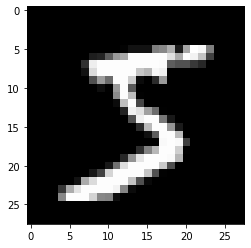

In [ ]:
# mean = 0.1307
# std = 0.3081
# n_strong = 1
# m_strong = 3

# n_weak = 1
# m_weak = 2

# fix_match_augmentation = TransformFixImage(
#                                            mean=mean,
#                                            std=std,
#                                            n_strong=n_strong,
#                                            m_strong=m_strong,
#                                            n_weak=n_weak,
#                                            m_weak=m_weak,
#                                          )

# train_loader_org = torchvision.datasets.MNIST(root ='./data',
#                                         download=True,
#                                         transform=transforms.Compose(
#         [transforms.ToTensor()]
#     ))
# images, labels = next(iter(train_loader_org))
# plt.imshow(images[0].reshape(28,28), cmap="gray")


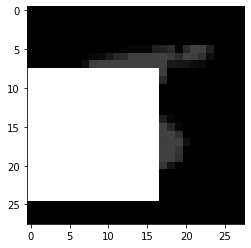

In [ ]:
# train_loader = torchvision.datasets.MNIST(root ='./data',
#                                         download=True,
#                                         transform=transforms.Compose(
#         [transforms.ToTensor(), fix_match_augmentation ]
#     ))
# (images_w, images_s), labels = next(iter(train_loader))
# plt.imshow(images_s[0].reshape(28,28), cmap="gray")

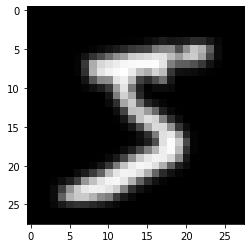

In [ ]:
# plt.imshow(images_w[0].reshape(28,28), cmap="gray")

### Conduct Experiment

#### Hyperparameters sanity check

In [ ]:
hparams

{'dataset': 'MNIST',
 'dataset_path': 'gdrive/My Drive/praca_magisterska/pytorch_lightning/datasets',
 'epoch_over': 'unlabeled_train_dataset',
 'isotropic_noise': 0.5,
 'l_batch_size': 32,
 'lambda_u': 0.1,
 'loss_function': 'CrossEntropyLoss',
 'lr': 0.03,
 'm_strong': 5,
 'm_weak': 2,
 'max_steps': 6000,
 'mean': 0.1307,
 'model_arch': 'FFNNMNIST_VAT',
 'momentum': 0.9,
 'mu': 7,
 'n_labeled': 96,
 'n_strong': 3,
 'n_weak': 1,
 'nesterov': False,
 'num_classes': 10,
 'opt_scheduler_interval': 'step',
 'optimizer_type': 'SGD',
 'save_best_model': True,
 'scheduler_type': 'LinearWarmUpLR',
 'seed': 42,
 'show_augmentation': False,
 'std': 0.3081,
 'test_batch_size': 16,
 'test_run': False,
 'threshold': 0.999,
 'train_test_split': 0.9,
 'training_method': 'FixMatch',
 'unl_batch_size': 224,
 'val_batch_size': 16,
 'valid_size_per_class': 96,
 'warmup_steps': 1000,
 'weight_decay': 0.0005}

#### Run

In [ ]:
set_seed(hparams['seed'])
experiment_name = dataset + "-" + model_arch + "-" + training_method  
project_name = "mr"

# logers

# neptune_logger = NeptuneLogger(
#                                project_name="m1f1/lightning-exps-text,
#                                close_after_fit=False,
#                                experiment_name=experiment_name,  # Optional,
#                                params=hparams, # Optional,
#                                tags=tags # Optional,
#                               )

wandb_logger = WandbLogger(project=project_name,
                           name=experiment_name,
                           tags=tags)

wandb_logger.log_hyperparams(hparams)


# callbacks
# early_stop_callback = EarlyStopping(
#                         monitor="val_loss",
#                         min_delta=0.0,
#                         patience=hparams['patience'],
#                         verbose=True,
#                         mode='min'
#                       )
lr_logger = LearningRateLogger()
# Path("./checkpoints").mkdir(parents=True, exist_ok=True)
# model_checkpoint = pl.callbacks.ModelCheckpoint(filepath='./checkpoints') # check if it overwrite last checkpoint

[print(f'{k}: {v}') for k, v in hparams.items()]

if hparams['save_best_model']:
  checkpoint_path = os.path.join(os.environ['MODEL_CHECKPOINT_PATH'], '{epoch}-{val_accuracy_error:.2f}')
  checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path,
                                        mode='min',
                                        monitor='val_accuracy_error',
                                        save_top_k=1)
else:
  checkpoint_callback = None

# training and evaluating model
trainer = pl.Trainer(
                gpus=1,
                # logger=neptune_logger,
                logger=wandb_logger,
                checkpoint_callback=checkpoint_callback,
                # early_stop_callback=early_stop_callback,
                # val_check_interval=hparams['val_check_interval'],
                # distributed_backend=hparams['distributed_backend'],
                # default_root_dir="./test_run_logs",
                callbacks=[lr_logger],
                fast_dev_run=hparams['test_run'],
              #  train_percent_check=0.001,
              #  val_percent_check=0.001,
                # min_epochs=hparams['min_epochs'],
                max_steps =hparams['max_steps'],
          )

model = LitComposableFramework(hparams)

wandb_logger.watch(model, log='all', log_freq=10)

trainer.fit(model)

if hparams['save_best_model']:
  model_loaded= LitComposableFramework.load_from_checkpoint(checkpoint_callback.best_model_path)
  trainer.test(model_loaded)
else:
  trainer.test(model)

# neptune_logger.experiment.log_artifact('./checkpoints')
# neptune_logger.experiment.log_artifact(os.environ['REQUIREMENTS_PATH'])
# neptune_logger.experiment.stop()

dataset: MNIST
num_classes: 10
dataset_path: gdrive/My Drive/praca_magisterska/pytorch_lightning/datasets
mean: 0.1307
std: 0.3081
training_method: FixMatch
l_batch_size: 32
unl_batch_size: 224
mu: 7
threshold: 0.999
lambda_u: 0.1
n_weak: 1
n_strong: 3
m_weak: 2
m_strong: 5
optimizer_type: SGD
lr: 0.03
momentum: 0.9
weight_decay: 0.0005
nesterov: False
scheduler_type: LinearWarmUpLR
warmup_steps: 1000
opt_scheduler_interval: step
show_augmentation: False
max_steps: 6000
model_arch: FFNNMNIST_VAT
isotropic_noise: 0.5
train_test_split: 0.9
seed: 42
val_batch_size: 16
test_batch_size: 16
n_labeled: 96
valid_size_per_class: 96
loss_function: CrossEntropyLoss
test_run: False
save_best_model: True
epoch_over: unlabeled_train_dataset


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


unique_labels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
number_of_categories : 10
total_iterations:  6000



  | Name     | Type             | Params
----------------------------------------------
0 | loss_fct | CrossEntropyLoss | 0     
1 | fc1      | Linear           | 942 K 
2 | fc2      | Linear           | 720 K 
3 | fc3      | Linear           | 180 K 
4 | fc4      | Linear           | 45 K  
5 | fc5      | Linear           | 1 K   
6 | bn1      | BatchNorm1d      | 2 K   
7 | bn2      | BatchNorm1d      | 1 K   
8 | bn3      | BatchNorm1d      | 600   
9 | bn4      | BatchNorm1d      | 300   


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:25: RuntimeWarning:

The metric you returned 0.3020833333333333 must be a `torch.Tensor` instance, checkpoint not saved HINT: what is the value of val_accuracy_error in validation_epoch_end()?

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning:

Please also save or load the state of the optimzer when saving or loading the scheduler.



/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:25: RuntimeWarning:

The metric you returned 0.28229166666666666 must be a `torch.Tensor` instance, checkpoint not saved HINT: what is the value of val_accuracy_error in validation_epoch_end()?



/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:25: RuntimeWarning:

The metric you returned 0.27708333333333335 must be a `torch.Tensor` instance, checkpoint not saved HINT: what is the value of val_accuracy_error in validation_epoch_end()?



/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:25: RuntimeWarning:

The metric you returned 0.26458333333333334 must be a `torch.Tensor` instance, checkpoint not saved HINT: what is the value of val_accuracy_error in validation_epoch_end()?



/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:25: RuntimeWarning:

The metric you returned 0.259375 must be a `torch.Tensor` instance, checkpoint not saved HINT: what is the value of val_accuracy_error in validation_epoch_end()?



/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:25: RuntimeWarning:

The metric you returned 0.24895833333333334 must be a `torch.Tensor` instance, checkpoint not saved HINT: what is the value of val_accuracy_error in validation_epoch_end()?



/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:25: RuntimeWarning:

The metric you returned 0.25104166666666666 must be a `torch.Tensor` instance, checkpoint not saved HINT: what is the value of val_accuracy_error in validation_epoch_end()?



/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:25: RuntimeWarning:

The metric you returned 0.24479166666666666 must be a `torch.Tensor` instance, checkpoint not saved HINT: what is the value of val_accuracy_error in validation_epoch_end()?



/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:25: RuntimeWarning:

The metric you returned 0.240625 must be a `torch.Tensor` instance, checkpoint not saved HINT: what is the value of val_accuracy_error in validation_epoch_end()?



/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:25: RuntimeWarning:

The metric you returned 0.24270833333333333 must be a `torch.Tensor` instance, checkpoint not saved HINT: what is the value of val_accuracy_error in validation_epoch_end()?



/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:25: RuntimeWarning:

The metric you returned 0.23333333333333334 must be a `torch.Tensor` instance, checkpoint not saved HINT: what is the value of val_accuracy_error in validation_epoch_end()?



/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:25: RuntimeWarning:

The metric you returned 0.22708333333333333 must be a `torch.Tensor` instance, checkpoint not saved HINT: what is the value of val_accuracy_error in validation_epoch_end()?



/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:25: RuntimeWarning:

The metric you returned 0.23020833333333332 must be a `torch.Tensor` instance, checkpoint not saved HINT: what is the value of val_accuracy_error in validation_epoch_end()?



/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:25: RuntimeWarning:

The metric you returned 0.225 must be a `torch.Tensor` instance, checkpoint not saved HINT: what is the value of val_accuracy_error in validation_epoch_end()?



/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:25: RuntimeWarning:

The metric you returned 0.228125 must be a `torch.Tensor` instance, checkpoint not saved HINT: what is the value of val_accuracy_error in validation_epoch_end()?



/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:25: RuntimeWarning:

The metric you returned 0.22916666666666666 must be a `torch.Tensor` instance, checkpoint not saved HINT: what is the value of val_accuracy_error in validation_epoch_end()?




unique_labels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
number_of_categories : 10
total_iterations:  6000


--------------------------------------------------------------------------------
TEST RESULTS
{'test_accuracy_error': 0.1815068493150685,
 'test_f1_error': 0.1815068493150685,
 'test_loss': 1.0792798,
 'test_max_confident': 0.99999976,
 'test_mean_confident': 0.9579403,
 'test_min_confident': 0.6609539,
 'test_precision_error': 0.1815068493150685,
 'test_recall_error': 0.1815068493150685,
 'test_std_confident': 0.09440742}
--------------------------------------------------------------------------------



In [ ]:
# df = pd.read_csv(str(Path(os.environ['DATASETS_PATH'])/'imdb_with_bt.csv'))
# df
# df = df.rename(columns={'intent': 'label', 'bt': 'paraphrases'})
# df.to_csv(str(Path(os.environ['DATASETS_PATH'])/'imdb_with_bt.csv'))

### Hyperparameter search


#### System spec


In [ ]:
# class LitYKConv_HPO(pl.LightningModule):

#   def __init__(self, hparams, trial):

#     super().__init__()
#     self.hparams = hparams

#     if self.hparams['with_VAT']:
#       xi_interval = list(map(float, hparams['xi'].split(',')))
#       eps_interval = list(map(float, hparams['eps'].split(',')))
#       ip_interval = list(map(int, hparams['ip'].split(',')))
#       alpha_interval = list(map(float, hparams['alpha'].split(',')))

#       self.xi = trial.suggest_uniform('xi', *xi_interval)
#       print('xi: ', self.xi)
#       self.eps = trial.suggest_uniform('eps', *eps_interval)
#       print('eps: ', self.eps)
#       self.ip = trial.suggest_int('ip', *ip_interval)
#       print('ip: ', self.ip)
#       self.alpha = trial.suggest_uniform('alpha', *alpha_interval)
#       print('alpha: ', self.alpha)

#     lr_interval = list(map(float, hparams['lr'].split(',')))
#     print(lr_interval)
#     kernel_num_interval = list(map(int, hparams['kernel_num'].split(','))) 
#     print(kernel_num_interval)
#     dropout_interval = list(map(float, hparams['dropout'].split(','))) 
#     print(dropout_interval)

#     self.lr = trial.suggest_loguniform('learning_rate', *lr_interval)
#     print('lr: ', self.lr)
#     self.Co = trial.suggest_int('kernel_num', *kernel_num_interval) #hparams['kernel_num']
#     print('kernel_num: ', self.Co)
#     dropout = trial.suggest_uniform('dropout', *dropout_interval)
#     print('dropout: ', dropout)
#     self.dropout = nn.Dropout(dropout)


#     self.embeder_dict = {
#                          'fastText': (create_ft_embeder, gensim_tokenizer),
#                          'spaCy':(create_spacy_nlp_embeder, lambda x: x)
#                         }
#     embeder, self.tokenizer_fun = self.embeder_dict[hparams['embeder_type']]
#     self.embeder = nlp #embeder()
#     self.D = hparams['embed_dim']
#     self.Ci = hparams['Ci'] 
    
#     self.loss_fct = getattr(nn, hparams['loss_function'])()
#     self.num_classes = hparams['num_classes']

#     self.Ks = list(map(int, hparams['kernel_sizes'].split(','))) # (3,4,5)
#     self.convs1 = nn.ModuleList([nn.Conv2d(self.Ci, self.Co, (K, self.D)) for K in self.Ks])
#     self.fc1 = nn.Linear(len(self.Ks) * self.Co, self.num_classes) 

#     self.total_iterations = 0 

#   def forward(self, x):
#       # print('org: ', x.size())
#       x = x.unsqueeze(self.Ci)  # (N, Ci, W, D)
#       # from pdb import set_trace as st
#       # st() 
#       # print(f'unsqueeze {self.Ci}: {x.size()}')
#       x = [F.relu(conv(x)).squeeze(3) for conv in self.convs1]  # [(N, Co, W), ...]*len(Ks)
#       # print(f'conv, relu, squeeze : {x.size()}')
#       x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]  # [(N, Co), ...]*len(Ks)
#       # print(f'max_pool1d, squeeze : {x.size()}')
#       x = torch.cat(x, 1)
#       # print(f' cat: {x.size()}')
#       x = self.dropout(x)  # (N, len(Ks)*Co)
#       logit = self.fc1(x)  # (N, C)
#       # print(f' logit: {logit.size()}')
#       return logit


#   def prepare_data(self):

#     if self.hparams['dataset'] == 'NLUHD':

#       not_none = lambda x: x["text"] is not None 
#       ds = lf.CsvDataset(self.hparams['dataset_path'], header=True).filter(not_none)
#       unique_labels = list(pd.DataFrame(ds).intent.unique())
#       le = preprocessing.LabelEncoder().fit(unique_labels)
#       print(f"Unique labels: {unique_labels}")
#       print(f"Number of unique labels: {len(unique_labels)}")
#       train, test = lf.cross_validation.split_dataset_random(ds,
#                                                             int(len(ds) * self.hparams['train_test_split']),
#                                                             seed=self.hparams['seed'])
#       preprocessor = partial(
#                             preprocess_NLUHD,
#                             self.hparams['model_type'],
#                             self.hparams['max_sentence_len'],
#                             self.tokenizer_dict[self.hparams['model_type']],
#                             le,
#                             )
      
#     elif self.hparams['dataset'] == 'MR':

#       preprocessor = partial(
#                             preprocess_MR,
#                             self.hparams,
#                             self.tokenizer_fun, 
#                             self.embeder,
#                             le,
#                             )

#     elif self.hparams['dataset'] == 'IMDB':

#       ds = lfds.Imdb('train') + lfds.Imdb('test')
#       ds = ds.map(lambda x: {'text': x[0], 'label': x[1]})
#       df = pd.DataFrame(ds)
#       # self.embeder.build_vocab(new_sentences, update=True)
#       # self.embeder.train(new_sentences, total_examples=len(new_sentences), epochs=)
#       print(df.info(memory_usage=True))
#       unique_labels = list(df.label.unique())
#       print(f'unique_labels: {unique_labels}')
#       print(f'number_of_categories : {len(unique_labels)}')
#       le = preprocessing.LabelEncoder().fit(unique_labels)
#       train, test = lf.cross_validation.split_dataset_random(ds,
#                                                              int(len(ds) * self.hparams['train_test_split']),
#                                                              seed=self.hparams['seed'])
#       preprocessor = partial(
#                              preprocess_IMDB,
#                              self.hparams,
#                              self.tokenizer_fun, 
#                              self.embeder,
#                              le,
#                             )
#     else:
#       raise ValueError('Wrong dataset name : {}'.format(self.hparams['dataset']))

    
#     train_df, test_df = pd.DataFrame(train), pd.DataFrame(test)
#     x_train, y_train = train_df['text'].values, train_df['label'].values
#     x_test, y_test = test_df['text'].values, test_df['label'].values

#     # split's parameters  
#     num_classes = len(unique_labels)
#     label_per_class = self.hparams['n_labeled'] // num_classes
#     valid_size = self.hparams['valid_size_per_class']

#     labeled_idx = []
#     unlabeled_idx = []
#     val_idx = []
    
#     for label in unique_labels:
#         idx = np.where(y_train == label)[0]
#         np.random.shuffle(idx)
#         labeled_idx.extend(idx[:label_per_class])
#         val_idx.extend(idx[label_per_class: label_per_class + valid_size])
#         unlabeled_idx.extend(idx[label_per_class + valid_size:])

#     x_labeled, y_labeled  = x_train[labeled_idx], y_train[labeled_idx]
#     x_unlabeled, y_unlabeled = x_train[unlabeled_idx], y_train[unlabeled_idx]
#     x_val, y_val = x_train[val_idx], y_train[val_idx]
    
#     train_labeled_dataset = SimpleTextDataset(x_labeled,
#                                               y_labeled,
#                                               transform=preprocessor)
    
#     train_unlabeled_dataset = SimpleTextDataset(x_unlabeled,
#                                                 y_unlabeled,
#                                                 transform=preprocessor)
    
#     self._train_dataset = TwoInOneDataset([train_labeled_dataset,
#                                             train_unlabeled_dataset])
    
#     self._val_dataset = SimpleTextDataset(x_val,
#                                           y_val,
#                                           transform=preprocessor)
    
#     self._test_dataset = SimpleTextDataset(x_test,
#                                            y_test,
#                                            transform=preprocessor)
    
#     self.total_iterations = len(train_unlabeled_dataset) // self.hparams['batch_size'] 


#   def train_dataloader(self):
#     return DataLoader(
#                       self._train_dataset,
#                       batch_size=self.hparams['batch_size'],
#                       num_workers=8,
#                       shuffle=True # without shuffle it want work cause it need to create map index before __get_item__ function
#                      )
    
  
#   def val_dataloader(self):
#     return DataLoader(
#                       self._val_dataset,
#                       batch_size=self.hparams['batch_size'],
#                       num_workers=8
#                      )
    
  
#   def test_dataloader(self):
#     return DataLoader(
#                       self._test_dataset,
#                       batch_size=self.hparams['batch_size'],
#                       num_workers=8
#                      )
    
  
#   def configure_optimizers(self):

#     optimizers = [
#                   torch.optim.Adam(self.parameters(), lr=self.lr),
#                  ]
#     schedulers = [
#                   {
#                     'scheduler': ReduceLROnPlateau(optimizers[0],'min', verbose=True), 
#                     'monitor': 'val_loss', # Default: val_loss
#                     'interval': 'epoch',
#                     'frequency': 1
#                   },
#                  ]

#     return optimizers, schedulers


#   def training_step(self, batch, batch_idx):

#     l_batch = batch[0]
#     l_texts = l_batch['embedding']
#     labels = l_batch['label']
#     unl_texts = batch[1]['embedding']

#     if self.hparams['with_VAT']:
#       vat_loss = VATLoss(xi=self.xi,
#                          eps=self.eps,
#                          ip=self.ip)
#       lds = vat_loss(self, unl_texts)

#     logits = self.forward(l_texts)
#     loss = self.loss_fct(logits, labels)

#     if self.hparams['with_VAT']:
#       loss += self.alpha * lds 

#     labels_hat = logits.max(dim=1)[1]

#     labels = labels.detach().cpu()
#     labels_hat = labels_hat.detach().cpu()
    
#     accuracy_error = torch.tensor(1 - accuracy_score(labels, labels_hat))
#     f1_error = torch.tensor(1 - f1_score(labels, labels_hat, average='micro'))
#     recall_error = torch.tensor(1 - recall_score(labels, labels_hat, average='micro'))
#     precision_error = torch.tensor(1 - precision_score(labels, labels_hat, average='micro'))

#     logs = {'train_loss': loss,
#             'train_accuracy_error': accuracy_error,
#             'train_f1_error': f1_error,
#             'train_recall_error': recall_error,
#             'train_precision_error': precision_error,
#            }  

#     if self.hparams['with_VAT']:
#       logs.update({'lds_loss': lds.item()})


#     return {'loss': loss,
#             'log': logs}


#   def validation_step(self, batch, batch_idx):
#     texts = batch['embedding']
#     labels = batch['label']
  
#     logits = self.forward(texts)
#     loss = self.loss_fct(logits, labels)
#     labels_hat = torch.argmax(logits, dim=1)

#     labels = labels.cpu()
#     labels_hat = labels_hat.cpu()

#     accuracy_error = torch.tensor(1 - accuracy_score(labels, labels_hat))
#     f1_error = torch.tensor(1 - f1_score(labels, labels_hat, average='micro'))
#     recall_error = torch.tensor(1 - recall_score(labels, labels_hat, average='micro'))
#     precision_error = torch.tensor(1 - precision_score(labels, labels_hat, average='micro'))
  
#     output = {
#             "val_loss": loss,
#             'accuracy_error': accuracy_error,
#             'f1_error': f1_error,
#             'recall_error': recall_error,
#             'precision_error': precision_error,
#             }
  
#     return output


#   def validation_epoch_end(self, outputs):
#     # CHANGE FOR TENSORS!!!!
#     val_acc = compute_global_metric(outputs, 'accuracy_error')
#     val_f1 = compute_global_metric(outputs, 'f1_error')
#     val_recall = compute_global_metric(outputs, 'recall_error')
#     val_precision = compute_global_metric(outputs, 'precision_error')
#     val_loss = compute_global_metric(outputs, "val_loss")

#     tqdm_dict = {
#                  "val_loss": val_loss,
#                  "val_acc": val_acc,
#                  "val_f1": val_f1,
#                  "val_recall": val_recall,
#                  "val_precision": val_precision,
#                 }
#     return {
#             "progress_bar": tqdm_dict,
#             "log": tqdm_dict,
#             "val_loss": val_loss,
#             'val_acc': val_acc,
#             'val_f1': val_f1
#            }


#   def test_step(self, batch, batch_idx):

#     texts = batch["embedding"]
#     labels = batch["label"]
  
#     logits = self.forward(texts)
#     loss = self.loss_fct(logits, labels)
#     labels_hat = torch.argmax(logits, dim=1)

#     labels = labels.cpu()
#     labels_hat = labels_hat.cpu()


#     accuracy_error = torch.tensor(1 - accuracy_score(labels, labels_hat))
#     f1_error = torch.tensor(1 - f1_score(labels, labels_hat, average='micro'))
#     recall_error = torch.tensor(1 - recall_score(labels, labels_hat, average='micro'))
#     precision_error = torch.tensor(1 - precision_score(labels, labels_hat, average='micro'))
  
#     return {
#             "test_loss": loss,
#             'accuracy_error': accuracy_error,
#             'f1_error': f1_error,
#             'recall_error': recall_error,
#             'precision_error': precision_error,
#            }


#   def test_epoch_end(self, outputs):

#     test_acc = compute_global_metric(outputs, 'accuracy_error') 
#     test_f1 = compute_global_metric(outputs, 'f1_error')
#     test_recall = compute_global_metric(outputs, 'recall_error')
#     test_precision = compute_global_metric(outputs, 'precision_error')
#     test_loss = compute_global_metric(outputs, "test_loss")

#     tqdm_dict = {
#                  "test_loss": test_loss,
#                  "test_acc": test_acc,
#                  "test_f1": test_f1,
#                  "test_recall": test_recall,
#                  "test_precision": test_precision,
#                 }
#     return {
#             "progress_bar": tqdm_dict,
#             "log": tqdm_dict,
#             "test_loss": test_loss,
#             'test_acc': test_acc,
#             'test_f1': test_f1
#            }

#### Define objective func


In [ ]:
# def objective(trial):
#   # nluhd_dataset_path = str(Path()/
#   #                         'gdrive'/
#   #                         'My Drive'/
#   #                         'praca_magisterska'/
#   #                         'pytorch_lightning'/
#   #                         'datasets'/
#   #                         'NLU-Data-Home-Domain-preprocessed-without-ner.csv')
#   hparams = {
#             # model architecture
#             'model_type': 'YoonKimConvNN',
#             'dropout':'0.2,0.7', 
#             'kernel_sizes': '3,4,5', # (3,4,5)
#             'kernel_num': '60,120', # interval
#             'Ci': 1,
#             'loss_function':'CrossEntropyLoss',
#             # pl trainer params
#             'seed': 42,
#             'monitor_value': 'val_acc',
#             'percent_valid_examples': 0.5, 
#             'test_run': False,
#             'with_VAT': True,
#             'max_epochs': 2,
#             'min_epochs': 1,
#             'val_check_interval': 0.5, 
#             'patience': 3, # early stopping callback parameter
#             'distributed_backend': 'dp',
#             # embeddings params
#             'embeder_type': "fastText",
#             'embed_dim': 300,
#             'max_sentence_len': 400,
#             # dataset params
#             'train_test_split': 0.8,
#             'batch_size': 32,
#             'n_labeled': 1000, # number of labeled samples 
#             'valid_size_per_class': 1000, # 68 class => n_val_samples = 68 * 10 
#             # optimizer params
#             'lr': '0.00001, 10',
#             # VAT params
#             'xi':'6,12',
#             'eps':'1,3',
#             'ip':'1,3',
#             'alpha':'1,3',
#             }
  
#   set_seed(hparams['seed'])
  
#   hparams.update({'dataset':'IMDB',
#                   'num_classes': 2})
  
  
#   # training and evaluating model
  
          
#   metrics_callback = MetricsCallback()
  
#   checkpoint_callback = pl.callbacks.ModelCheckpoint(
#           os.path.join(os.environ['RESULT_PATH'],
#                        "trial_{}".format(trial.number),
#                        "{epoch}"), monitor=hparams['monitor_value']
#       )
  
#   trainer = pl.Trainer(
#                   gpus=1 if torch.cuda.is_available() else None,
#                   logger=False,
#                   # val_percent_check=hparams['percent_valid_examples'],
#                   checkpoint_callback=checkpoint_callback,
#                   max_epochs=hparams['max_epochs'],
#                   fast_dev_run=hparams['test_run'],
#                   callbacks=[metrics_callback],
#                   early_stop_callback=PyTorchLightningPruningCallback(trial, monitor=hparams['monitor_value'])
#             )
  
#   model = LitYKConv_HPO(hparams, trial=trial)
  
#   trainer.fit(model)
#   return metrics_callback.metrics[-1]["val_acc"]


  

#### Run trails

In [ ]:
# pruning = True

# pruner = optuna.pruners.MedianPruner() if pruning else optuna.pruners.NopPruner()

# study = optuna.create_study(direction="minimize", pruner=pruner)
# study.optimize(objective, n_trials=20, timeout=None)

# print("Number of finished trials: {}".format(len(study.trials)))

# print("Best trial:")
# trial = study.best_trial

# print("  Value: {}".format(trial.value))

# print("  Params: ")
# for key, value in trial.params.items():
#     print("    {}: {}".format(key, value))
# # shutil.rmtree(os.environ['RESULT_PATH'])

In [ ]:
# optuna.visualization.plot_intermediate_values(study)

In [ ]:
# optuna.visualization.plot_param_importances(study)